In [1]:
import os
from collections import Counter
from pathlib import Path

import anndata
import altair as alt
import pandas as pd
import numpy as np
import scipy
import scanpy as sc
import seaborn as sns
import umap
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler


import mgitools.os_helpers as os_helpers

In [2]:
from pollock.models.model import predict_from_anndata, embed_from_anndata
from pollock.models.explain import explain_predictions

In [3]:
DATA_DIR = '../benchmarking/sandbox/figure_data_v3'
Path(DATA_DIR).mkdir(parents=True, exist_ok=True)

###### train model if needed

In [10]:
adata = sc.read_h5ad('/home/estorrs/data/single_cell_classification/tumor/BR/scRNA/brca_with_immune.h5ad')

In [55]:
# adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
# sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
# sc.pp.highly_variable_genes(adata, n_top_genes=3000)
# adata.raw = adata
# adata = adata[:, adata.var.highly_variable]
# sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
# sc.pp.scale(adata, max_value=10)

In [56]:
# sc.tl.pca(adata, svd_solver='arpack')
# sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
# sc.tl.umap(adata)

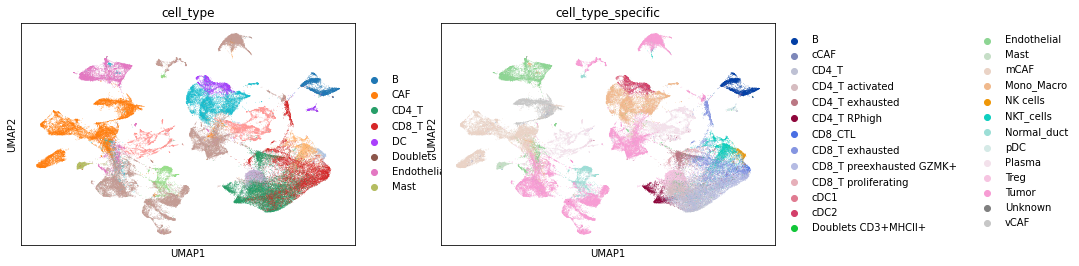

In [57]:
sc.pl.umap(adata, color=['cell_type', 'cell_type_specific'])

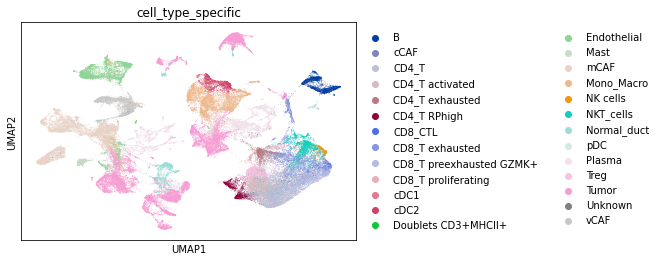

In [58]:
sc.pl.umap(adata, color=['cell_type_specific'])

In [11]:
cell_type_map = {
    'B': 'B cell',
    'CD4_T': 'CD4 T cell',
    'CD4_T activated': 'CD4 T cell - activated',
    'CD4_T exhausted': 'CD4 T cell - exhausted',
    'CD8_CTL': 'CD8 T cell - CTL',
    'CD8_T exhausted': 'CD8 T cell - exhausted',
    'CD8_T preexhausted GZMK+': 'CD8 T cell - preexhausted',
    'CD8_T proliferating': 'CD8 T cell - proliferating',
    'cDC1': 'cDC1',
    'cDC2': 'cDC2',
    'Mast': 'Mast',
    'Mono_Macro': 'Monocyte/Macrophage',
    'NK cells': 'NK',
    'NKT_cells': 'NKT',
    'pDC': 'pDC',
    'Plasma': 'Plasma',
    'Treg': 'Treg',
}
immune = adata[[True if c in cell_type_map else False for c in adata.obs['cell_type_specific']]]
immune.obs['cell_type'] = [cell_type_map[c] for c in immune.obs['cell_type_specific']]
adata.obs['renamed_cell_type']= [cell_type_map.get(c, c) for c in adata.obs['cell_type_specific']]

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Trying to set attribute `.obs` of view, copying.


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'renamed_cell_type' as categorical


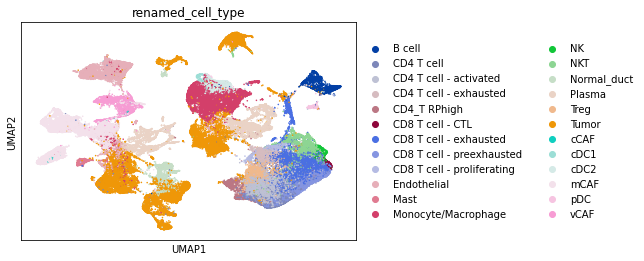

In [60]:
p_adata = adata.copy()
p_adata = p_adata[p_adata.obs['renamed_cell_type']!='Unknown']
p_adata = p_adata[p_adata.obs['renamed_cell_type']!='Doublets CD3+MHCII+']
p_adata = p_adata[p_adata.obs['renamed_cell_type']!='CD4_T']
sc.pl.umap(p_adata, color=['renamed_cell_type'], size=10)

... storing 'cell_type' as categorical


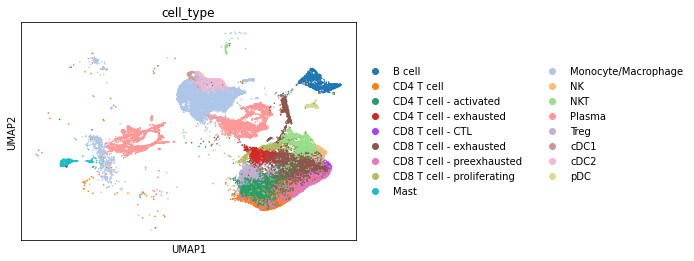

In [11]:
sc.pl.umap(immune, color=['cell_type'], size=10)

In [12]:
counts_adata = immune.copy()
counts_adata.X = counts_adata.layers['counts']
counts_adata

AnnData object with n_obs × n_vars = 49063 × 27131
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'sample', 'tissue_type', 'cell_type', 'cell_type_specific', 'Piece_ID', 'Clinical_Subtype', 'doublet_score', 'predicted_doublet', 'Composite_PAM50', 'active.ident'
    uns: 'cell_type_colors', 'cell_type_specific_colors'
    obsm: 'X_umap'
    layers: 'counts'

In [13]:
set(counts_adata.X[0].toarray().flatten())

{0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 31.0,
 32.0,
 35.0,
 36.0,
 39.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 56.0,
 73.0,
 93.0,
 118.0,
 410.0}

In [14]:
from collections import Counter
from pollock.models.model import PollockDataset, PollockModel, balancedish_training_generator

In [15]:
Counter(counts_adata.obs['cell_type'])

Counter({'CD8 T cell - CTL': 705,
         'CD8 T cell - preexhausted': 4190,
         'NK': 527,
         'Monocyte/Macrophage': 8049,
         'Treg': 2721,
         'CD4 T cell': 7104,
         'CD8 T cell - exhausted': 4099,
         'cDC2': 2079,
         'NKT': 3328,
         'CD4 T cell - activated': 2745,
         'B cell': 2972,
         'cDC1': 268,
         'pDC': 385,
         'Plasma': 7092,
         'Mast': 755,
         'CD8 T cell - proliferating': 529,
         'CD4 T cell - exhausted': 1515})

In [16]:
source = pd.DataFrame.from_dict({k:[v] for k, v in Counter(counts_adata.obs['cell_type']).items()})
source = source.transpose()
source.columns = ['Cell Count']
source['Cell Type'] = source.index.to_list()
source

,Cell Count,Cell Type
CD8 T cell - CTL,705,CD8 T cell - CTL
CD8 T cell - preexhausted,4190,CD8 T cell - preexhausted
NK,527,NK
Monocyte/Macrophage,8049,Monocyte/Macrophage
Treg,2721,Treg
CD4 T cell,7104,CD4 T cell
CD8 T cell - exhausted,4099,CD8 T cell - exhausted
cDC2,2079,cDC2
NKT,3328,NKT
CD4 T cell - activated,2745,CD4 T cell - activated


In [17]:
alt.Chart(source).mark_bar().encode(
    x='Cell Type:O',
    y="Cell Count:Q",
    # The highlight will be set on the result of a conditional statement
).properties()

alt.Chart(...)

In [18]:
train, rest = balancedish_training_generator(counts_adata, 'cell_type', n_per_cell_type=1000, split=1.)
train

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


View of AnnData object with n_obs × n_vars = 13619 × 27131
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'sample', 'tissue_type', 'cell_type', 'cell_type_specific', 'Piece_ID', 'Clinical_Subtype', 'doublet_score', 'predicted_doublet', 'Composite_PAM50', 'active.ident'
    uns: 'cell_type_colors', 'cell_type_specific_colors'
    obsm: 'X_umap'
    layers: 'counts'

In [19]:
## train module
pds = PollockDataset(train.copy(), cell_type_key='cell_type', n_per_cell_type=500,
                    oversample=True, dataset_type='training', )

2021-04-05 14:48:52,346 input dataset shape: (13619, 27131)
2021-04-05 14:48:52,348 possible cell types: ['B cell', 'CD4 T cell', 'CD4 T cell - activated', 'CD4 T cell - exhausted', 'CD8 T cell - CTL', 'CD8 T cell - exhausted', 'CD8 T cell - preexhausted', 'CD8 T cell - proliferating', 'Mast', 'Monocyte/Macrophage', 'NK', 'NKT', 'Plasma', 'Treg', 'cDC1', 'cDC2', 'pDC']
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [20]:
pm = PollockModel(pds.cell_types, pds.train_adata.shape[1], alpha=.0005, latent_dim=25, )

In [21]:
pm.fit(pds, epochs=20)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-05 14:49:27,802 epoch: 1, train loss: 25.373483657836914, val loss: 27.63041114807129
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-05 14:49:47,148 epoch: 2, train loss: 25.148277282714844, val loss: 27.230682373046875
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-05 14:50:05,871 epoch: 3, train loss: 24.62128448486328, val loss: 26.78582763671875
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtyp

In [38]:
module_fp = '/home/estorrs/data/single_cell_classification/tumor/BR/scRNA/immune_pollock_module_04012021'
pm.save(pds, module_fp)

In [39]:
import json
summary = json.load(open(os.path.join(module_fp, 'summary.json')))

In [40]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

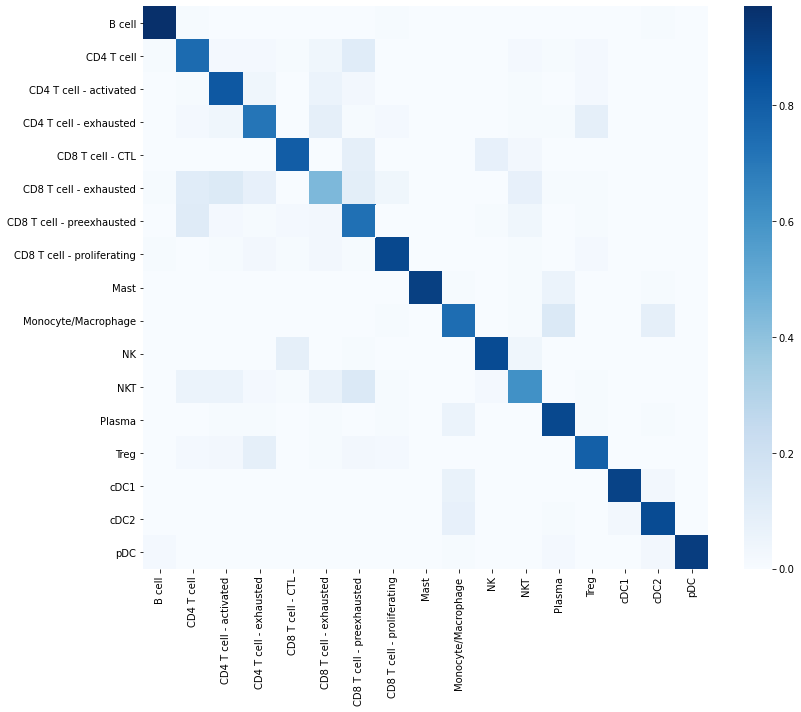

In [41]:
confusion_matrix = pd.DataFrame(data=summary['validation']['confusion_matrix'],
                                columns=summary['model_parameters']['cell_types'],
                                index=summary['model_parameters']['cell_types'])
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(confusion_matrix, cmap='Blues')
plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, 'brca_immune_confusion_matrix.pdf'))

In [35]:
DATA_DIR

'../benchmarking/sandbox/figure_data_v3'

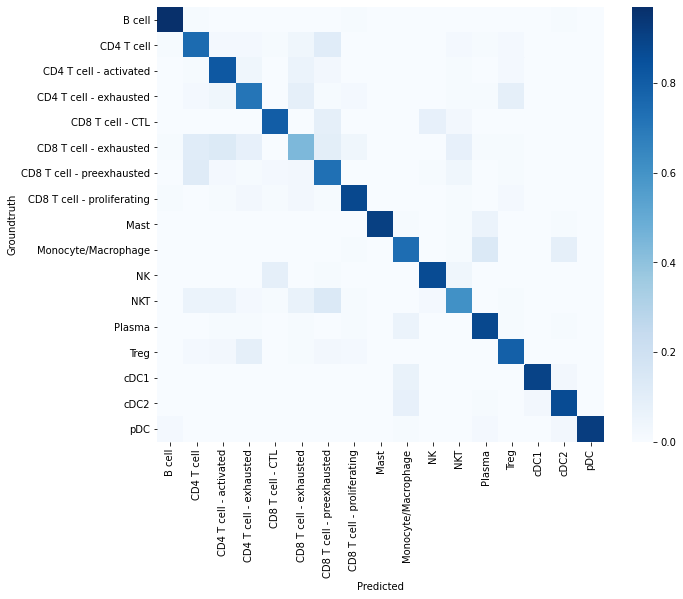

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axs = plt.subplots(figsize=(10, 8))
confusion_matrix = pd.DataFrame(data=pm.summary['validation']['confusion_matrix'], columns=pm.class_names,
                  index=pm.class_names)
sns.heatmap(confusion_matrix, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Groundtruth')
plt.savefig(os.path.join(DATA_DIR, 'brca_immune_confusion_matrix.pdf'))

NameError: name 'pm' is not defined

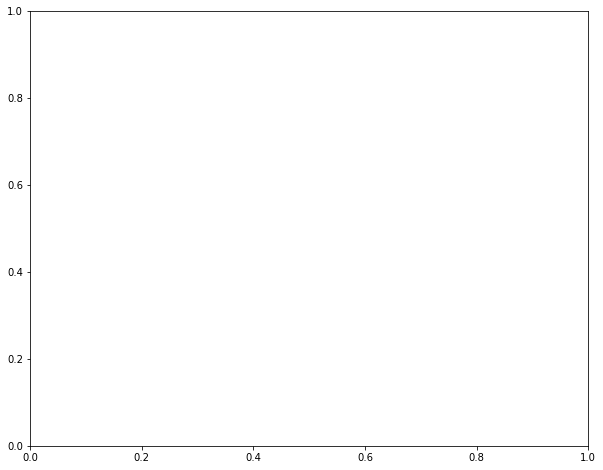

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axs = plt.subplots(figsize=(10, 8))
confusion_matrix = pd.DataFrame(data=pm.summary['validation']['confusion_matrix'], columns=pm.class_names,
                  index=pm.class_names)
sns.heatmap(confusion_matrix, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Groundtruth')
plt.savefig(os.path.join(DATA_DIR, 'brca_immune_confusion_matrix.pdf'))

In [149]:
import json
summary = json.load(open(os.path.join(module_fp, 'summary.json')))

In [150]:
summary['model_parameters']

{'alpha': 0.0005,
 'learning_rate': 0.0001,
 'latent_dim': 25,
 'cell_types': ['B cell',
  'CD4 T cell',
  'CD4 T cell - activated',
  'CD4 T cell - exhausted',
  'CD8 T cell - CTL',
  'CD8 T cell - exhausted',
  'CD8 T cell - preexhausted',
  'CD8 T cell - proliferating',
  'Mast',
  'Monocyte/Macrophage',
  'NK',
  'NKT',
  'Plasma',
  'Treg',
  'cDC1',
  'cDC2',
  'pDC']}

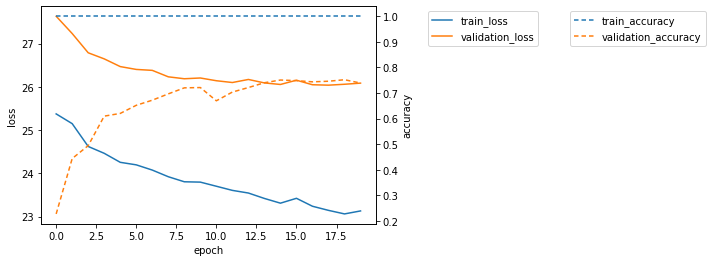

In [151]:
loss, label, epoch = [], [], []
for k in ['train_loss', 'validation_loss']:
    loss += summary['history'][k]
    label += [k] * len(summary['history'][k])
    epoch += list(range(len(summary['history'][k])))
df = pd.DataFrame.from_dict({'label': label, 'loss': loss, 'epoch': epoch})

sns.lineplot(x='epoch', y='loss', data=df, hue='label')
plt.legend(bbox_to_anchor=(1.5, 1))

accuracy, label = [], []
for k in ['train_accuracy', 'validation_accuracy']:
    accuracy += summary['history'][k]
    label += [k] * len(summary['history'][k])
df = pd.DataFrame.from_dict({'label': label, 'accuracy': accuracy, 'epoch': epoch})

ax2 = plt.twinx()
sns.lineplot(x='epoch', y='accuracy', data=df, hue='label', ax=ax2, style='label',
                 dashes=[(3,2), (3,2)])
plt.legend(bbox_to_anchor=(2., 1))

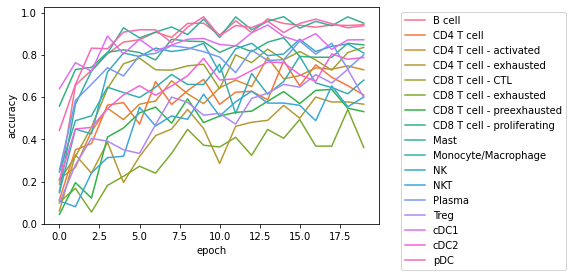

In [152]:
loss, label, epoch = [], [], []
for k in ['cell_type_val_f1']:
    for cell_type, vals in summary['history'][k].items():
        loss += vals
        label += [cell_type] * len(vals)
        epoch += list(range(len(vals)))
    
df = pd.DataFrame.from_dict({
    'cell_type': label,
    'accuracy': loss,
    'epoch': epoch
})

sns.lineplot(x='epoch', y='accuracy', data=df, hue='cell_type')
plt.legend(bbox_to_anchor=(1.05, 1))

In [27]:
# adata = sc.read_h5ad('../benchmarking/data/11302020_harmonized/teir_2/snRNAseq/ccrcc.h5ad')

In [24]:
data_dir = '../benchmarking/data/01272021_harmonized/teir_1/'
fps = sorted(os_helpers.listfiles(data_dir, regex=r'.h5ad'))
fps = [fp for fp in fps if '_val.h5ad' not in fp and '_train.h5ad' not in fp]
fps

['../benchmarking/data/01272021_harmonized/teir_1/scRNAseq/brca.h5ad',
 '../benchmarking/data/01272021_harmonized/teir_1/scRNAseq/cesc.h5ad',
 '../benchmarking/data/01272021_harmonized/teir_1/scRNAseq/hnscc.h5ad',
 '../benchmarking/data/01272021_harmonized/teir_1/scRNAseq/melanoma.h5ad',
 '../benchmarking/data/01272021_harmonized/teir_1/scRNAseq/myeloma.h5ad',
 '../benchmarking/data/01272021_harmonized/teir_1/scRNAseq/pdac.h5ad',
 '../benchmarking/data/01272021_harmonized/teir_1/snATACseq/brca.h5ad',
 '../benchmarking/data/01272021_harmonized/teir_1/snATACseq/brca_gene_activity.h5ad',
 '../benchmarking/data/01272021_harmonized/teir_1/snATACseq/brca_motif.h5ad',
 '../benchmarking/data/01272021_harmonized/teir_1/snATACseq/brca_peaks.h5ad',
 '../benchmarking/data/01272021_harmonized/teir_1/snATACseq/ccrcc.h5ad',
 '../benchmarking/data/01272021_harmonized/teir_1/snATACseq/ccrcc_gene_activity.h5ad',
 '../benchmarking/data/01272021_harmonized/teir_1/snATACseq/ccrcc_motif.h5ad',
 '../benchmar

In [25]:
data_map = {}
for fp in fps:
    pieces = fp.split('/')
    dtype = pieces[-2]
    dataset = pieces[-1].replace('.h5ad', '')
    if dtype not in data_map: data_map[dtype] = {}
    data_map[dtype][dataset] = fp
    
d = data_map.pop('snATACseq')
for k, v in d.items():
    disease = v.split('/')[-1].split('_')[0]
    dtype = '_'.join(v.split('/')[-1].replace('.h5ad', '').split('_')[1:])
    
    dtype = f'snATACseq_{dtype}'
    if dtype not in data_map: data_map[dtype] = {}
    data_map[dtype][disease] = v
    
data_map

{'scRNAseq': {'brca': '../benchmarking/data/01272021_harmonized/teir_1/scRNAseq/brca.h5ad',
  'cesc': '../benchmarking/data/01272021_harmonized/teir_1/scRNAseq/cesc.h5ad',
  'hnscc': '../benchmarking/data/01272021_harmonized/teir_1/scRNAseq/hnscc.h5ad',
  'melanoma': '../benchmarking/data/01272021_harmonized/teir_1/scRNAseq/melanoma.h5ad',
  'myeloma': '../benchmarking/data/01272021_harmonized/teir_1/scRNAseq/myeloma.h5ad',
  'pdac': '../benchmarking/data/01272021_harmonized/teir_1/scRNAseq/pdac.h5ad'},
 'snRNAseq': {'brca': '../benchmarking/data/01272021_harmonized/teir_1/snRNAseq/brca.h5ad',
  'ccrcc': '../benchmarking/data/01272021_harmonized/teir_1/snRNAseq/ccrcc.h5ad',
  'gbm': '../benchmarking/data/01272021_harmonized/teir_1/snRNAseq/gbm.h5ad'},
 'snATACseq_': {'brca.h5ad': '../benchmarking/data/01272021_harmonized/teir_1/snATACseq/brca.h5ad',
  'ccrcc.h5ad': '../benchmarking/data/01272021_harmonized/teir_1/snATACseq/ccrcc.h5ad',
  'gbm.h5ad': '../benchmarking/data/01272021_harmo

apply model to scRNAseq

In [26]:
data_map.pop('snRNAseq')
data_map.pop('snATACseq_gene_activity')
data_map.pop('snATACseq_motif')
data_map.pop('snATACseq_peaks')
data_map.pop('snATACseq_')

{'brca.h5ad': '../benchmarking/data/01272021_harmonized/teir_1/snATACseq/brca.h5ad',
 'ccrcc.h5ad': '../benchmarking/data/01272021_harmonized/teir_1/snATACseq/ccrcc.h5ad',
 'gbm.h5ad': '../benchmarking/data/01272021_harmonized/teir_1/snATACseq/gbm.h5ad'}

In [27]:
data_map

{'scRNAseq': {'brca': '../benchmarking/data/01272021_harmonized/teir_1/scRNAseq/brca.h5ad',
  'cesc': '../benchmarking/data/01272021_harmonized/teir_1/scRNAseq/cesc.h5ad',
  'hnscc': '../benchmarking/data/01272021_harmonized/teir_1/scRNAseq/hnscc.h5ad',
  'melanoma': '../benchmarking/data/01272021_harmonized/teir_1/scRNAseq/melanoma.h5ad',
  'myeloma': '../benchmarking/data/01272021_harmonized/teir_1/scRNAseq/myeloma.h5ad',
  'pdac': '../benchmarking/data/01272021_harmonized/teir_1/scRNAseq/pdac.h5ad'}}

In [28]:
def incorporate_predictions(adata, model_fp):
    preds = predict_from_anndata(adata, model_fp)
    emb = embed_from_anndata(adata, model_fp)

    adata.obs = pd.concat((adata.obs, preds), axis=1)
    adata.obsm['pollock_embedding'] = emb.values
    adata.obsm['pollock_umap'] = umap.UMAP().fit_transform(StandardScaler().fit_transform(emb.values))
    
    return adata

In [29]:
a = sc.read_h5ad('../benchmarking/data/11302020_harmonized/teir_1/scRNAseq/brca.h5ad')
set(a.obs['cell_type'])

{'B cell',
 'CD4 T cell',
 'CD8 T cell',
 'Dendritic',
 'Endothelial',
 'Erythrocyte',
 'Fibroblast',
 'Malignant',
 'Mast',
 'Monocyte',
 'NK',
 'Plasma',
 'Treg'}

In [30]:
# get rid of non-immune original classifications
exclude = ['Acinar', 'Endothelial', 'Epithelial', 'Erythrocyte', 'Fibroblast', 'Islet', 'Malignant',
          'Platlete', 'Tuft']

In [31]:
for dtype, d in data_map.items():
    for disease, fp in d.items():
        print(dtype, disease)
        adata = sc.read_h5ad(fp)
        adata.obs.columns = adata.obs.columns.astype(str)
        adata.var.columns = adata.var.columns.astype(str)
        adata = adata[[True if c not in exclude else False for c in adata.obs['cell_type']]]
        
        data_map[dtype][disease] = incorporate_predictions(adata, module_fp)

scRNAseq brca


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-05 14:58:16,592 0 genes in training set are missing from prediction set
2021-04-05 14:58:16,918 starting batch 1 of 5
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-05 14:58:17,049 0 genes in training set are missing from prediction set
2021-04-05 14:58:39,091 starting batch 2 of 5
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-05 14:58:39,285 0 genes in training set are missing from prediction set
2021-04-05 14:59:02,908 starting batch 3 of 5
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-05 14:59:03,119 0 genes in training set are missing from prediction set
2021-04-05 14:59:27,394 starting batch 4 of 5
is_categorical is deprecated and will be removed in a future version.  Use is_ca

scRNAseq cesc


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-05 15:02:49,563 4469 genes in training set are missing from prediction set
2021-04-05 15:02:49,970 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-05 15:02:50,100 4469 genes in training set are missing from prediction set
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-05 15:03:15,204 4469 genes in training set are missing from prediction set
2021-04-05 15:03:15,784 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-05 15:03:15,956 4469 genes in training set are missing from prediction set


scRNAseq hnscc


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-05 15:03:56,482 1308 genes in training set are missing from prediction set
2021-04-05 15:03:56,838 starting batch 1 of 14
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-05 15:03:56,962 1308 genes in training set are missing from prediction set
2021-04-05 15:04:21,456 starting batch 2 of 14
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-05 15:04:21,630 1308 genes in training set are missing from prediction set
2021-04-05 15:04:44,377 starting batch 3 of 14
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-05 15:04:44,571 1308 genes in training set are missing from prediction set
2021-04-05 15:05:09,861 starting batch 4 of 14
is_categorical is deprecated and will be removed in a future ver

scRNAseq melanoma


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-05 15:17:11,176 5596 genes in training set are missing from prediction set
2021-04-05 15:17:11,558 starting batch 1 of 3
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-05 15:17:11,680 5596 genes in training set are missing from prediction set
2021-04-05 15:17:35,079 starting batch 2 of 3
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-05 15:17:35,210 5596 genes in training set are missing from prediction set
2021-04-05 15:17:58,345 starting batch 3 of 3
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-05 15:17:58,521 5596 genes in training set are missing from prediction set
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-05

scRNAseq myeloma


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-05 15:19:44,218 7651 genes in training set are missing from prediction set
2021-04-05 15:19:44,778 starting batch 1 of 8
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-05 15:19:45,140 7651 genes in training set are missing from prediction set
2021-04-05 15:20:14,593 starting batch 2 of 8
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-05 15:20:14,779 7651 genes in training set are missing from prediction set
2021-04-05 15:20:42,574 starting batch 3 of 8
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-05 15:20:42,752 7651 genes in training set are missing from prediction set
2021-04-05 15:21:09,150 starting batch 4 of 8
is_categorical is deprecated and will be removed in a future version

scRNAseq pdac


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-05 15:28:03,997 298 genes in training set are missing from prediction set
2021-04-05 15:28:04,398 starting batch 1 of 10
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-05 15:28:04,535 298 genes in training set are missing from prediction set
2021-04-05 15:28:29,298 starting batch 2 of 10
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-05 15:28:29,492 298 genes in training set are missing from prediction set
2021-04-05 15:28:53,532 starting batch 3 of 10
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-05 15:28:53,663 298 genes in training set are missing from prediction set
2021-04-05 15:29:17,324 starting batch 4 of 10
is_categorical is deprecated and will be removed in a future version

lets look at the predictions

In [236]:
data_map['scRNAseq']['pdac']

AnnData object with n_obs × n_vars = 92715 × 28756
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type', 'sample', 'treatment', 'tissue', 'ident', 'predicted_cell_type', 'cell_type_probability', 'probability_B cell', 'probability_CD4 T cell', 'probability_CD4 T cell - activated', 'probability_CD4 T cell - exhausted', 'probability_CD8 T cell - CTL', 'probability_CD8 T cell - exhausted', 'probability_CD8 T cell - preexhausted', 'probability_CD8 T cell - proliferating', 'probability_Mast', 'probability_Monocyte/Macrophage', 'probability_NK', 'probability_NKT', 'probability_Plasma', 'probability_Treg', 'probability_cDC1', 'probability_cDC2', 'probability_pDC', 'disease'
    var: 'sct.detection_rate', 'sct.gmean', 'sct.variance', 'sct.residual_mean', 'sct.residual_variance', 'sct.variable'
    obsm: 'X_pca', 'X_umap', 'pollock_embedding', 'pollock_umap'
    layers: 'logcounts'

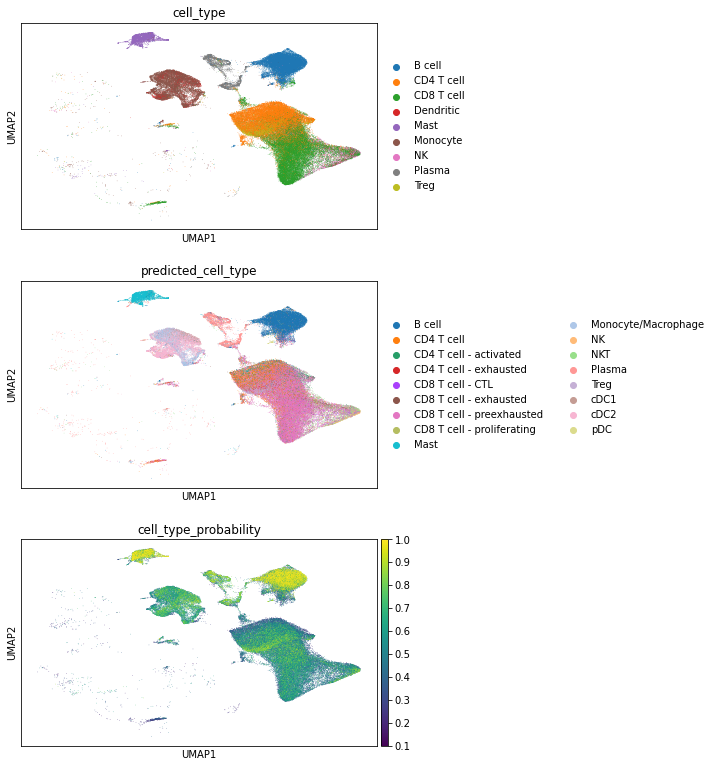

In [238]:
sc.pl.umap(data_map['scRNAseq']['pdac'], color=['cell_type', 'predicted_cell_type', 'cell_type_probability'],
          ncols=1)

In [33]:
data_map['scRNAseq']['myeloma'].obs['predicted_cell_type']

,predicted_cell_type,predicted_cell_type
27522_1_AAACCTGAGATGTCGG-1,NA,CD8 T cell - CTL
27522_1_AAACCTGAGCTGATAA-1,NA,cDC2
27522_1_AAACCTGGTCAACTGT-1,NA,CD8 T cell - CTL
27522_1_AAACCTGGTCGGATCC-1,NA,B cell
27522_1_AAACGGGAGGTAGCTG-1,NA,B cell
...,...,...
Normal_sorted_170607_GTGCAGCTCTCTAGGA-1,NA,Plasma
Normal_sorted_170607_TACTTGTCAAGGACTG-1,NA,B cell
Normal_sorted_170607_TCAGCTCTCAGTCAGT-1,NA,Plasma
Normal_sorted_170607_TGACAACAGGACATTA-1,NA,Plasma


In [34]:
d = data_map['scRNAseq']['myeloma']
data_map['scRNAseq']['myeloma'].obs = d.obs.iloc[:, [i for i in range(len(d.obs.columns)) if i!=list(d.obs.columns).index('predicted_cell_type')]]


In [35]:
sorted(set(data_map['scRNAseq']['myeloma'].obs['predicted_cell_type']))

['B cell',
 'CD4 T cell',
 'CD4 T cell - activated',
 'CD4 T cell - exhausted',
 'CD8 T cell - CTL',
 'CD8 T cell - exhausted',
 'CD8 T cell - preexhausted',
 'CD8 T cell - proliferating',
 'Mast',
 'Monocyte/Macrophage',
 'NK',
 'NKT',
 'Plasma',
 'Treg',
 'cDC1',
 'cDC2',
 'pDC']

In [36]:
# immune = [
# #     'Basophil',
#  'CD4 CTL',
#  'CD4 T cell',
#  'CD4 T cell activated',
#  'CD4 T cell naive',
#  'CD4/CD8 proliferating',
#  'CD8 CTL',
#  'CD8 T cell preexhausted',
# #  'Macrophage',
# #  'Macrophage proliferating',
#  'NK cell strong',
#  'NK cell weak',
# #  'Plasma',
#  'TRM',
#  'Treg',
# #  'cDC',
# #  'pDC'
# ]
# i2 = ['CD4 T cell', 'CD8 T cell', 'NK', 'Treg', 'Monocyte', 'Mast', 'B', 'Dendritic', 'Plasma']
# import matplotlib.pyplot as plt
# # for dtype, d in data_map.items():
# filtered_data_map = {}
# for disease, adata in data_map['scRNAseq'].items():
#     print(f'{dtype}_{disease}')
#     pdf = adata.copy()
#     pdf.obs['predicted_cell_type'] = [c if o in i2 else o
#                                       for c, o in zip(pdf.obs['predicted_cell_type'], pdf.obs['cell_type'])]
# #     pdf = adata[[True if c in i2 else False for c in adata.obs['cell_type']]]
# #     pdf = adata[[True if c in immune else False for c in adata.obs['predicted_cell_type']]]
# #     pdf = pdf[[True if c in i2 else False for c in pdf.obs['cell_type']]]
#     sc.pl.embedding(adata, basis='pollock_umap', 
#             color=['cell_type', 'predicted_cell_type', 'cell_type_probability'], ncols=3)
#     filtered_data_map[disease] = pdf
# #     plt.title(disease)
#     plt.show()

In [37]:
# sc.pl.embedding(filtered_data_map['pdac'], basis='pollock_umap',
#                 color=['cell_type', 'predicted_cell_type'],
#                ncols=1)

In [38]:
combined = None
for disease, adata in data_map['scRNAseq'].items():
    adata.obs['disease'] = disease
    if combined is None:
        combined = adata
    else:
        combined = anndata.concat((combined, adata))
combined.obs_names_make_unique()
combined

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 390210 × 17540
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type', 'ident', 'predicted_cell_type', 'cell_type_probability', 'probability_B cell', 'probability_CD4 T cell', 'probability_CD4 T cell - activated', 'probability_CD4 T cell - exhausted', 'probability_CD8 T cell - CTL', 'probability_CD8 T cell - exhausted', 'probability_CD8 T cell - preexhausted', 'probability_CD8 T cell - proliferating', 'probability_Mast', 'probability_Monocyte/Macrophage', 'probability_NK', 'probability_NKT', 'probability_Plasma', 'probability_Treg', 'probability_cDC1', 'probability_cDC2', 'probability_pDC', 'disease'
    obsm: 'pollock_embedding', 'pollock_umap'
    layers: 'logcounts'

In [43]:
# incorporate training vs validation
train_cells = set(pds.train_adata.obs.index)
def func(cid, dataset):
    if cid in train_cells: return 'train'
    elif dataset == 'brca': return 'validation'
    return 'test'
combined.obs['model_dataset'] = [func(cid, d) for cid, d in zip(combined.obs.index, combined.obs['disease'])]

In [45]:
set(combined.obs['predicted_cell_type'])

{'B cell',
 'CD4 T cell',
 'CD4 T cell - activated',
 'CD4 T cell - exhausted',
 'CD8 T cell - CTL',
 'CD8 T cell - exhausted',
 'CD8 T cell - preexhausted',
 'CD8 T cell - proliferating',
 'Mast',
 'Monocyte/Macrophage',
 'NK',
 'NKT',
 'Plasma',
 'Treg',
 'cDC1',
 'cDC2',
 'pDC'}

In [46]:
set(combined.obs['cell_type'])

{'B cell',
 'CD4 T cell',
 'CD8 T cell',
 'Dendritic',
 'Mast',
 'Monocyte',
 'NK',
 'Plasma',
 'Treg'}

In [47]:
combined.write_h5ad(os.path.join(DATA_DIR, 'cross_disease_predictions_panimmune_breast_module.h5ad'))

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'orig.ident' as categorical
... storing 'SCT_snn_res.0.5' as categorical
... storing 'seurat_clusters' as categorical
... storing 'cell_type' as categorical
... storing 'ident' as categorical
... storing 'predicted_cell_type' as categorical
... storing 'disease' as categorical
... storing 'model_dataset' as categorical


In [4]:
combined = sc.read_h5ad(os.path.join(DATA_DIR, 'cross_disease_predictions_panimmune_breast_module.h5ad'))

In [6]:
genes = list({v for vs in marker_genes.values() for v in vs})
smol = combined[:, genes]
smol

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


View of AnnData object with n_obs × n_vars = 390210 × 28
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type', 'ident', 'predicted_cell_type', 'cell_type_probability', 'probability_B cell', 'probability_CD4 T cell', 'probability_CD4 T cell - activated', 'probability_CD4 T cell - exhausted', 'probability_CD8 T cell - CTL', 'probability_CD8 T cell - exhausted', 'probability_CD8 T cell - preexhausted', 'probability_CD8 T cell - proliferating', 'probability_Mast', 'probability_Monocyte/Macrophage', 'probability_NK', 'probability_NKT', 'probability_Plasma', 'probability_Treg', 'probability_cDC1', 'probability_cDC2', 'probability_pDC', 'disease', 'model_dataset'
    obsm: 'pollock_embedding', 'pollock_umap'
    layers: 'logcounts'

In [7]:
r = {v:k for k, vs in marker_genes.items() for v in vs}

In [8]:
# for dan
smol.var['cell_type'] = [r[c] for c in smol.var.index]
smol.var.loc['CD3G', 'cell_type'] = 'T cell - general'
smol.var

Trying to set attribute `.var` of view, copying.


,cell_type
GNLY,NK
FCER1A,Mast
CD14,Macrophage
LYZ,Macrophage
CD7,NK
TOP2A,T cell - proliferating
IL7R,T cell - Naive
NCAM1,NK - Weak
CD8A,CD8 T cell
PDCD1,T cell - exausted


In [9]:
smol.obs = smol.obs[['cell_type', 'predicted_cell_type', 'disease', 'model_dataset']]
smol.obs['manual_teir1_annotation'] = smol.obs['cell_type'].to_list()
smol.obs

,cell_type,predicted_cell_type,disease,model_dataset,manual_teir1_annotation
_HT062B1_S1PA_AAACCCACACAAATGA-1,CD8 T cell,CD8 T cell - CTL,brca,train,CD8 T cell
_HT062B1_S1PA_AAACGAAGTAGGGAGG-1,CD8 T cell,CD8 T cell - preexhausted,brca,validation,CD8 T cell
_HT062B1_S1PA_AAACGAATCGTGGCGT-1,CD8 T cell,CD8 T cell - CTL,brca,validation,CD8 T cell
_HT062B1_S1PA_AAACGCTGTGGAATGC-1,CD8 T cell,CD8 T cell - CTL,brca,validation,CD8 T cell
_HT062B1_S1PA_AAACGCTGTGGGAGAG-1,CD8 T cell,CD8 T cell - CTL,brca,validation,CD8 T cell
...,...,...,...,...,...
HT168P1_S1H4_TTTGACTTCTAGAACC-1,CD8 T cell,CD8 T cell - preexhausted,pdac,test,CD8 T cell
HT168P1_S1H4_TTTGGAGCAGCGTTGC-1,CD8 T cell,CD8 T cell - preexhausted,pdac,test,CD8 T cell
HT168P1_S1H4_TTTGGTTCACTCAAGT-1,Monocyte,cDC2,pdac,test,Monocyte
HT168P1_S1H4_TTTGTTGTCATTCGTT-1,CD8 T cell,CD8 T cell - preexhausted,pdac,test,CD8 T cell


In [12]:
smol.obs['cell_type'] = [immune.obs.loc[c, 'cell_type'] if c in immune.obs.index else None
                        for c in smol.obs.index]

In [13]:
smol.obs.index.name = 'cell_id'

In [14]:
smol.obs

,cell_type,predicted_cell_type,disease,model_dataset,manual_teir1_annotation
cell_id,,,,,
_HT062B1_S1PA_AAACCCACACAAATGA-1,CD8 T cell - CTL,CD8 T cell - CTL,brca,train,CD8 T cell
_HT062B1_S1PA_AAACGAAGTAGGGAGG-1,CD8 T cell - preexhausted,CD8 T cell - preexhausted,brca,validation,CD8 T cell
_HT062B1_S1PA_AAACGAATCGTGGCGT-1,CD8 T cell - CTL,CD8 T cell - CTL,brca,validation,CD8 T cell
_HT062B1_S1PA_AAACGCTGTGGAATGC-1,CD8 T cell - CTL,CD8 T cell - CTL,brca,validation,CD8 T cell
_HT062B1_S1PA_AAACGCTGTGGGAGAG-1,CD8 T cell - CTL,CD8 T cell - CTL,brca,validation,CD8 T cell
...,...,...,...,...,...
HT168P1_S1H4_TTTGACTTCTAGAACC-1,None,CD8 T cell - preexhausted,pdac,test,CD8 T cell
HT168P1_S1H4_TTTGGAGCAGCGTTGC-1,None,CD8 T cell - preexhausted,pdac,test,CD8 T cell
HT168P1_S1H4_TTTGGTTCACTCAAGT-1,None,cDC2,pdac,test,Monocyte


In [15]:
immune.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mito,nCount_SCT,nFeature_SCT,SCT_snn_res.0.5,seurat_clusters,sample,tissue_type,cell_type,cell_type_specific,Piece_ID,Clinical_Subtype,doublet_score,predicted_doublet,Composite_PAM50,active.ident
_HT062B1_S1PA_AAACCCACACAAATGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,4837.0,1378,0.043829,4154.0,1378,2,2,HT062B1,tumor,CD8 T cell - CTL,CD8_CTL,HT062B1_S1PA,TNBC,0.036018,0,Her2,CD8_CTL
_HT062B1_S1PA_AAACGAAGTAGGGAGG-1,TWCE-HT062B1-S1PAA1A1Z1B1,2256.0,934,0.050089,3281.0,934,2,2,HT062B1,tumor,CD8 T cell - preexhausted,CD8_T preexhausted GZMK+,HT062B1_S1PA,TNBC,0.027729,0,Her2,CD8_T preexhausted GZMK+
_HT062B1_S1PA_AAACGAATCGTGGCGT-1,TWCE-HT062B1-S1PAA1A1Z1B1,3098.0,1172,0.096191,3487.0,1172,2,2,HT062B1,tumor,CD8 T cell - CTL,CD8_CTL,HT062B1_S1PA,TNBC,0.030261,0,Her2,CD8_CTL
_HT062B1_S1PA_AAACGCTGTGGAATGC-1,TWCE-HT062B1-S1PAA1A1Z1B1,5985.0,2181,0.054135,4478.0,2175,2,2,HT062B1,tumor,CD8 T cell - CTL,CD8_CTL,HT062B1_S1PA,TNBC,0.028969,0,Her2,CD8_CTL
_HT062B1_S1PA_AAACGCTGTGGGAGAG-1,TWCE-HT062B1-S1PAA1A1Z1B1,2895.0,1130,0.024525,3428.0,1130,2,2,HT062B1,tumor,CD8 T cell - CTL,CD8_CTL,HT062B1_S1PA,TNBC,0.017602,0,Her2,CD8_CTL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
_HT171B1_BC2_TTTGTTGCAAGAGATT-1,TWCE-HT171B1-BC2,3713.0,1611,0.033935,3726.0,1611,8,8,HT171B1,tumor,Treg,Treg,HT171B1_S1H8,TNBC,0.062757,0,Basal,Treg
_HT171B1_BC2_TTTGTTGCACCAGACC-1,TWCE-HT171B1-BC2,4717.0,1660,0.063600,4178.0,1660,8,8,HT171B1,tumor,CD4 T cell - exhausted,CD4_T exhausted,HT171B1_S1H8,TNBC,0.104260,0,Basal,CD4_T exhausted
_HT171B1_BC2_TTTGTTGTCCCAAGCG-1,TWCE-HT171B1-BC2,3236.0,1392,0.051916,3482.0,1392,8,8,HT171B1,tumor,CD8 T cell - exhausted,CD8_T exhausted,HT171B1_S1H8,TNBC,0.027347,0,Basal,CD8_T exhausted
_HT171B1_BC2_TTTGTTGTCCTCACCA-1,TWCE-HT171B1-BC2,13163.0,4124,0.036162,3946.0,1808,7,7,HT171B1,tumor,Monocyte/Macrophage,Mono_Macro,HT171B1_S1H8,TNBC,0.233279,0,Basal,Mono_Macro


In [16]:
smol.var.index.name = 'gene'

In [17]:
smol.write_h5ad(os.path.join(DATA_DIR, 'cross_disease_predictions_panimmune_breast_module_smol.h5ad'))

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'cell_type' as categorical
... storing 'manual_teir1_annotation' as categorical
... storing 'cell_type' as categorical


###### mini gene expression analysis

In [18]:
marker_genes

{'B cell': ['MS4A1'],
 'CD4 T cell': ['CD3G', 'CD4'],
 'CD8 T cell': ['CD3G', 'CD8A'],
 'T cell - Activated': ['CD69', 'CD28'],
 'T cell - Naive': ['IL7R'],
 'T cell - Effector': ['GZMA'],
 'T cell - Memory': ['CX3CR1'],
 'T cell - Regulatory': ['FOXP3'],
 'T cell - pre-exausted': ['GZMK'],
 'T cell - exausted': ['PDCD1', 'LAG3'],
 'T cell - proliferating': ['MKI67', 'TOP2A'],
 'NK': ['GNLY', 'CD7'],
 'NK - Strong': ['NKG7'],
 'NK - Weak': ['NCAM1'],
 'Mast': ['KIT', 'FCER1A'],
 'Macrophage': ['CD14', 'FCGR3A', 'LYZ'],
 'cDC': ['BATF3', 'IDO1'],
 'pDC': ['IL3RA'],
 'Plasma': ['SDC1']}

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


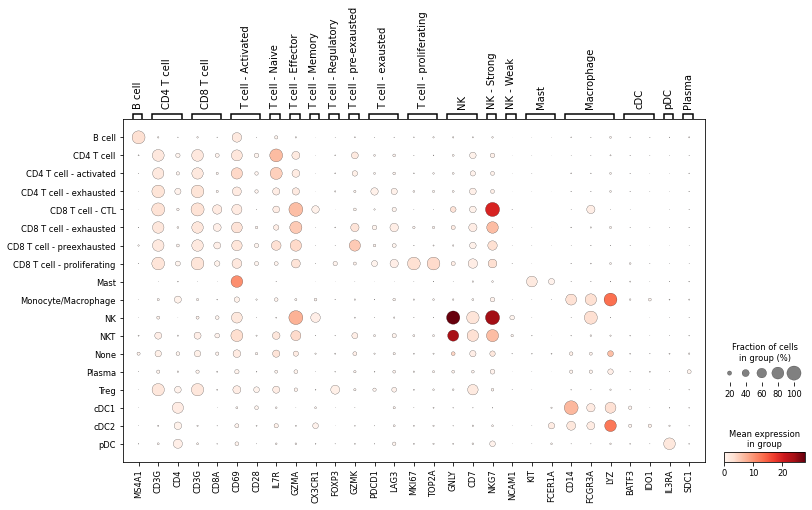

In [48]:
sc.pl.dotplot(smol, var_names=marker_genes, groupby='cell_type', save='expression_dots.pdf')

In [156]:
combined.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mito,nCount_SCT,nFeature_SCT,SCT_snn_res.0.5,seurat_clusters,cell_type,ident,...,probability_Monocyte/Macrophage,probability_NK,probability_NKT,probability_Plasma,probability_Treg,probability_cDC1,probability_cDC2,probability_pDC,disease,model_dataset
_HT062B1_S1PA_AAACCCACACAAATGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,4837.0,1378,0.043829,4154.0,1378,2,2,CD8 T cell,2,...,0.00,0.05,0.01,0.00,0.00,0.00,0.00,0.00,brca,train
_HT062B1_S1PA_AAACGAAGTAGGGAGG-1,TWCE-HT062B1-S1PAA1A1Z1B1,2256.0,934,0.050089,3281.0,934,2,2,CD8 T cell,2,...,0.00,0.04,0.10,0.01,0.14,0.00,0.01,0.00,brca,validation
_HT062B1_S1PA_AAACGAATCGTGGCGT-1,TWCE-HT062B1-S1PAA1A1Z1B1,3098.0,1172,0.096191,3487.0,1172,2,2,CD8 T cell,2,...,0.00,0.03,0.01,0.00,0.00,0.00,0.00,0.00,brca,validation
_HT062B1_S1PA_AAACGCTGTGGAATGC-1,TWCE-HT062B1-S1PAA1A1Z1B1,5985.0,2181,0.054135,4478.0,2175,2,2,CD8 T cell,2,...,0.00,0.04,0.01,0.00,0.01,0.00,0.00,0.00,brca,validation
_HT062B1_S1PA_AAACGCTGTGGGAGAG-1,TWCE-HT062B1-S1PAA1A1Z1B1,2895.0,1130,0.024525,3428.0,1130,2,2,CD8 T cell,2,...,0.00,0.07,0.00,0.00,0.00,0.00,0.00,0.00,brca,validation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HT168P1_S1H4_TTTGACTTCTAGAACC-1,TWCE-HT168P1-BC4-HT168P1-BC4_1,3422.0,1409,0.069258,4443.0,1409,9,9,CD8 T cell,CD8_T,...,0.01,0.07,0.22,0.00,0.00,0.00,0.00,0.00,pdac,test
HT168P1_S1H4_TTTGGAGCAGCGTTGC-1,TWCE-HT168P1-BC4-HT168P1-BC4_1,3112.0,1270,0.087082,4360.0,1273,19,19,CD8 T cell,CD8_T,...,0.02,0.00,0.15,0.00,0.00,0.00,0.00,0.00,pdac,test
HT168P1_S1H4_TTTGGTTCACTCAAGT-1,TWCE-HT168P1-BC4-HT168P1-BC4_1,1031.0,438,0.017459,3579.0,688,19,19,Monocyte,Macrophage,...,0.26,0.00,0.00,0.24,0.00,0.14,0.27,0.03,pdac,test
HT168P1_S1H4_TTTGTTGTCATTCGTT-1,TWCE-HT168P1-BC4-HT168P1-BC4_1,7440.0,2132,0.001882,5836.0,2129,10,10,CD8 T cell,CD8_T,...,0.00,0.10,0.23,0.00,0.02,0.00,0.00,0.01,pdac,test


In [231]:
source = combined.obs[['disease', 'cell_type', 'predicted_cell_type']]
source

,disease,cell_type,predicted_cell_type
_HT062B1_S1PA_AAACCCACACAAATGA-1,brca,CD8 T cell,CD8 T cell - CTL
_HT062B1_S1PA_AAACGAAGTAGGGAGG-1,brca,CD8 T cell,CD8 T cell - preexhausted
_HT062B1_S1PA_AAACGAATCGTGGCGT-1,brca,CD8 T cell,CD8 T cell - CTL
_HT062B1_S1PA_AAACGCTGTGGAATGC-1,brca,CD8 T cell,CD8 T cell - CTL
_HT062B1_S1PA_AAACGCTGTGGGAGAG-1,brca,CD8 T cell,CD8 T cell - CTL
...,...,...,...
HT168P1_S1H4_TTTGACTTCTAGAACC-1,pdac,CD8 T cell,CD8 T cell - preexhausted
HT168P1_S1H4_TTTGGAGCAGCGTTGC-1,pdac,CD8 T cell,CD8 T cell - preexhausted
HT168P1_S1H4_TTTGGTTCACTCAAGT-1,pdac,Monocyte,cDC2
HT168P1_S1H4_TTTGTTGTCATTCGTT-1,pdac,CD8 T cell,CD8 T cell - preexhausted


In [232]:
sorted(set(source['cell_type']))

['B cell',
 'CD4 T cell',
 'CD8 T cell',
 'Dendritic',
 'Mast',
 'Monocyte',
 'NK',
 'Plasma',
 'Treg']

In [220]:
sorted(set(source['predicted_cell_type']))

['B cell',
 'CD4 T cell',
 'CD4 T cell - activated',
 'CD4 T cell - exhausted',
 'CD8 T cell - CTL',
 'CD8 T cell - exhausted',
 'CD8 T cell - preexhausted',
 'CD8 T cell - proliferating',
 'Mast',
 'Monocyte/Macrophage',
 'NK',
 'NKT',
 'Plasma',
 'Treg',
 'cDC1',
 'cDC2',
 'pDC']

In [221]:
mapping = {
    'B cell': ['B cell'],
    'CD4 T cell': ['CD4 T cell',
 'CD4 T cell - activated',
 'CD4 T cell - exhausted',],
    'CD8 T cell': ['CD8 T cell - CTL',
 'CD8 T cell - exhausted',
 'CD8 T cell - preexhausted',
 'CD8 T cell - proliferating',],
    'Dendritic': ['cDC1',
 'cDC2',
 'pDC'],
    'Mast': ['Mast'],
    'Monocyte': ['Monocyte/Macrophage'],
    'NK': ['NK', 'NKT'],
    'Plasma': ['Plasma'],
    'Treg': ['Treg']
}

In [222]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [223]:
tups = [f'{a}_{b}' for a, b in zip(source['cell_type'], source['predicted_cell_type'])]
counts = Counter(tups)
colors = sns.color_palette().as_hex()
data = []
o1, o2 = sorted(set(source['cell_type'])), sorted(set(source['predicted_cell_type']))
labels = o1 + [o + ' ' for o in o2]
for c1 in o1:
    for c2 in o2:
        data.append([c1, labels.index(c1), c2 + ' ', labels.index(c2 + ' '), counts[f'{c1}_{c2}'],
                    colors[labels.index(c1)]])
source = pd.DataFrame(data=data, columns=['manual annotation', 'manual annotation index',
                                          'predicted', 'predicted index', 'count', 'color'])
source

,manual annotation,manual annotation index,predicted,predicted index,count,color
0,B cell,0,B cell,9,46198,#1f77b4
1,B cell,0,CD4 T cell,10,341,#1f77b4
2,B cell,0,CD4 T cell - activated,11,59,#1f77b4
3,B cell,0,CD4 T cell - exhausted,12,33,#1f77b4
4,B cell,0,CD8 T cell - CTL,13,1,#1f77b4
...,...,...,...,...,...,...
148,Treg,8,Plasma,21,100,#bcbd22
149,Treg,8,Treg,22,9757,#bcbd22
150,Treg,8,cDC1,23,0,#bcbd22
151,Treg,8,cDC2,24,10,#bcbd22


In [224]:
# filter out connections with < n cells so the diagram doesn't look clutered
source = source[source['count']>100]

In [225]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels,
#       color = 
    ),
    link = dict(
      source = source['manual annotation index'], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = source['predicted index'],
      value = source['count'],
      color = source['color']
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

In [230]:
source

,manual annotation,manual annotation index,predicted,predicted index,count,color
0,B cell,0,B cell,9,46198,#1f77b4
1,B cell,0,CD4 T cell,10,341,#1f77b4
6,B cell,0,CD8 T cell - preexhausted,15,597,#1f77b4
7,B cell,0,CD8 T cell - proliferating,16,333,#1f77b4
11,B cell,0,NKT,20,165,#1f77b4
...,...,...,...,...,...,...
141,Treg,8,CD8 T cell - exhausted,14,207,#bcbd22
142,Treg,8,CD8 T cell - preexhausted,15,1916,#bcbd22
143,Treg,8,CD8 T cell - proliferating,16,447,#bcbd22
147,Treg,8,NKT,20,266,#bcbd22


In [235]:
smol.obs

,cell_type,predicted_cell_type,disease,model_dataset,manual_teir1_annotation
cell_id,,,,,
_HT062B1_S1PA_AAACCCACACAAATGA-1,CD8 T cell - CTL,CD8 T cell - CTL,brca,train,CD8 T cell
_HT062B1_S1PA_AAACGAAGTAGGGAGG-1,CD8 T cell - preexhausted,CD8 T cell - preexhausted,brca,validation,CD8 T cell
_HT062B1_S1PA_AAACGAATCGTGGCGT-1,CD8 T cell - CTL,CD8 T cell - CTL,brca,validation,CD8 T cell
_HT062B1_S1PA_AAACGCTGTGGAATGC-1,CD8 T cell - CTL,CD8 T cell - CTL,brca,validation,CD8 T cell
_HT062B1_S1PA_AAACGCTGTGGGAGAG-1,CD8 T cell - CTL,CD8 T cell - CTL,brca,validation,CD8 T cell
...,...,...,...,...,...
HT168P1_S1H4_TTTGACTTCTAGAACC-1,None,CD8 T cell - preexhausted,pdac,test,CD8 T cell
HT168P1_S1H4_TTTGGAGCAGCGTTGC-1,None,CD8 T cell - preexhausted,pdac,test,CD8 T cell
HT168P1_S1H4_TTTGGTTCACTCAAGT-1,None,cDC2,pdac,test,Monocyte


In [72]:
smol.obs.to_csv(os.path.join(DATA_DIR, 'for_dan_cell_metadata.txt'), sep='\t')

In [73]:
smol.var.to_csv(os.path.join(DATA_DIR, 'for_dan_gene_metadata.txt'), sep='\t')

In [74]:
expression_counts = pd.DataFrame(data=smol.X.toarray(), columns=smol.var.index,
                                 index=smol.obs.index)
expression_counts

gene,FCGR3A,KIT,LYZ,GZMK,MS4A1,CD14,IL7R,CD7,FCER1A,CD69,...,MKI67,CD8A,CD28,GNLY,TOP2A,FOXP3,PDCD1,IDO1,CD4,GZMA
cell_id,,,,,,,,,,,,,,,,,,,,,
_HT062B1_S1PA_AAACCCACACAAATGA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0
_HT062B1_S1PA_AAACGAAGTAGGGAGG-1,0.0,0.0,0.0,13.0,0.0,0.0,18.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
_HT062B1_S1PA_AAACGAATCGTGGCGT-1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
_HT062B1_S1PA_AAACGCTGTGGAATGC-1,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,2.0,8.0
_HT062B1_S1PA_AAACGCTGTGGGAGAG-1,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HT168P1_S1H4_TTTGACTTCTAGAACC-1,0.0,0.0,0.0,9.0,0.0,0.0,4.0,1.0,0.0,12.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
HT168P1_S1H4_TTTGGAGCAGCGTTGC-1,0.0,0.0,0.0,13.0,0.0,0.0,0.0,1.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0
HT168P1_S1H4_TTTGGTTCACTCAAGT-1,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
expression_counts.to_csv(os.path.join(DATA_DIR, 'for_dan_counts.txt'), sep='\t')

In [78]:
DATA_DIR

'../benchmarking/sandbox/figure_data_v3'

In [79]:
sc.pp.normalize_total(combined, 10000)
sc.pp.log1p(combined)
# sc.pp.scale(combined)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'cell_type' as categorical
... storing 'predicted_cell_type' as categorical
... storing 'disease' as categorical


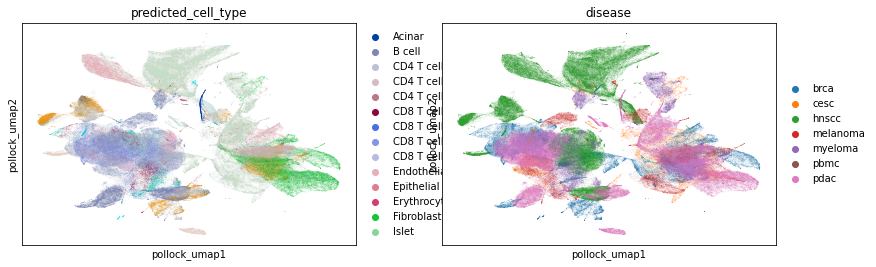

In [80]:
sc.pl.embedding(combined, basis='pollock_umap', color=['predicted_cell_type', 'disease'])

In [83]:
from collections import Counter
def plot_proportion(adata, x, y, percentage=True):
    samples = sorted(set(adata.obs[x]))
    cell_types = sorted(set(adata.obs[y]))

    data = []
    for s in samples:
        mini = adata.obs[adata.obs[x]==s]
        counts = Counter(mini[y])
        for c in cell_types:
            data.append([s, c, counts.get(c, 0)/mini.shape[0] if percentage else counts.get(c, 0)])
    df = pd.DataFrame(data=data)
    df.columns = [x, y, 'fraction' if percentage else 'count']

    return alt.Chart(df).mark_bar().encode(
        x=x,
        y='fraction' if percentage else 'count',
        color=y
    )
plot_proportion(combined[[True if c in pds.cell_types else False
                          for c in combined.obs['predicted_cell_type']]], 'disease', 'predicted_cell_type')

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


alt.Chart(...)

In [ ]:
## explain the brca


In [80]:
set(data_map['scRNAseq']['brca'].obs['cell_type'])

{'B cell',
 'CD4 T cell',
 'CD8 T cell',
 'Dendritic',
 'Mast',
 'Monocyte',
 'NK',
 'Plasma',
 'Treg'}

In [81]:
to_explained = {}
from pollock.models.model import balancedish_training_generator
for disease, adata in data_map['scRNAseq'].items():
    explain, rest = balancedish_training_generator(adata, cell_type_key='predicted_cell_type',
                                                   n_per_cell_type=50, oversample=False,
                                        split=1.)
    background, _ = balancedish_training_generator(rest, cell_type_key='predicted_cell_type', n_per_cell_type=5,
                                                   oversample=False,
                                               split=1.)
    print(disease, explain.shape)
    w = explain_predictions(explain.copy(), background.copy(), module_fp, prediction_key='predicted_cell_type')
    to_explained[disease] = w


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'predicted_cell_type' as categorical
... storing 'disease' as categorical
Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
... storing 'predicted_cell_type' as categorical
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
... storing 'disease' as categorical


brca (850, 27131)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-06 14:34:44,411 0 genes in training set are missing from prediction set
2021-04-06 14:34:45,035 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-06 14:34:45,134 0 genes in training set are missing from prediction set
2021-04-06 14:34:48,660 0 genes in training set are missing from prediction set
2021-04-06 14:34:50,742 (850, 27131)
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'predicted_cell_type' as categorical
... storing 'disease' as categorical
Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation

cesc (844, 22928)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-06 15:56:54,964 4469 genes in training set are missing from prediction set
2021-04-06 15:56:55,615 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-06 15:56:55,733 4469 genes in training set are missing from prediction set
2021-04-06 15:56:59,836 4469 genes in training set are missing from prediction set
2021-04-06 15:57:01,383 (844, 27131)
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'predicted_cell_type' as categorical
... storing 'disease' as categorical
Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Ob

hnscc (850, 26929)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-06 17:16:51,183 1308 genes in training set are missing from prediction set
2021-04-06 17:16:51,698 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-06 17:16:51,797 1308 genes in training set are missing from prediction set
2021-04-06 17:16:55,123 1308 genes in training set are missing from prediction set
2021-04-06 17:16:56,471 (850, 27131)
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'predicted_cell_type' as categorical
... storing 'disease' as categorical
Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Ob

melanoma (793, 23452)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-06 18:34:36,709 5596 genes in training set are missing from prediction set
2021-04-06 18:34:37,336 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-06 18:34:37,940 5596 genes in training set are missing from prediction set
2021-04-06 18:34:40,860 5596 genes in training set are missing from prediction set
2021-04-06 18:34:42,112 (793, 27131)
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'predicted_cell_type' as categorical
... storing 'disease' as categorical
Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Ob

myeloma (803, 24020)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-06 19:50:52,376 7651 genes in training set are missing from prediction set
2021-04-06 19:50:52,902 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-06 19:50:53,002 7651 genes in training set are missing from prediction set
2021-04-06 19:50:56,234 7651 genes in training set are missing from prediction set
2021-04-06 19:50:57,820 (803, 27131)
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'predicted_cell_type' as categorical
... storing 'disease' as categorical
Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Ob

pdac (850, 28756)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-06 21:11:04,725 298 genes in training set are missing from prediction set
2021-04-06 21:11:05,219 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-04-06 21:11:05,320 298 genes in training set are missing from prediction set
2021-04-06 21:11:08,398 298 genes in training set are missing from prediction set
2021-04-06 21:11:09,644 (850, 27131)


In [35]:
to_explained = {}
from pollock.models.model import balancedish_training_generator
for disease, adata in filtered_data_map.items():
    explain, rest = balancedish_training_generator(adata, cell_type_key='predicted_cell_type',
                                                   n_per_cell_type=50, oversample=False,
                                        split=1.)
    background, _ = balancedish_training_generator(rest, cell_type_key='predicted_cell_type', n_per_cell_type=10,
                                                   oversample=False,
                                               split=1.)
    print(disease, explain.shape)
    w = explain_predictions(explain.copy(), background.copy(), module_fp, prediction_key='predicted_cell_type')
    to_explained[disease] = w


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'disease' as categorical
Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
... storing 'disease' as categorical


brca (850, 27131)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 15:41:02,110 0 genes in training set are missing from prediction set
2021-01-12 15:41:02,674 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 15:41:02,770 0 genes in training set are missing from prediction set
2021-01-12 15:41:06,085 0 genes in training set are missing from prediction set
2021-01-12 15:41:07,993 (850, 27131)
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'disease' as categorical
Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call 

cesc (850, 22928)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 17:00:53,451 4469 genes in training set are missing from prediction set
2021-01-12 17:00:54,003 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 17:00:54,417 4469 genes in training set are missing from prediction set
2021-01-12 17:00:58,185 4469 genes in training set are missing from prediction set
2021-01-12 17:01:00,171 (850, 27131)
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'disease' as categorical
Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them uniq

hnscc (850, 26929)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 18:21:57,734 1308 genes in training set are missing from prediction set
2021-01-12 18:21:58,315 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 18:21:58,419 1308 genes in training set are missing from prediction set
2021-01-12 18:22:01,684 1308 genes in training set are missing from prediction set
2021-01-12 18:22:03,070 (850, 27131)
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'disease' as categorical
Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them uniq

melanoma (850, 23452)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 19:41:19,802 5593 genes in training set are missing from prediction set
2021-01-12 19:41:20,486 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 19:41:20,618 5593 genes in training set are missing from prediction set
2021-01-12 19:41:24,002 5593 genes in training set are missing from prediction set
2021-01-12 19:41:25,462 (850, 27131)
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'disease' as categorical


pbmc (362, 32738)


Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
... storing 'disease' as categorical
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 20:16:40,503 8620 genes in training set are missing from prediction set
2021-01-12 20:16:41,082 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 20:16:41,193 8620 genes in training set are missing from prediction set
2021-01-12 20:16:42,757 8620 genes in training set are missing from prediction set
2021-01-12 20:16:44,087 (362, 27131)
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.

pdac (844, 28756)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 21:34:40,506 298 genes in training set are missing from prediction set
2021-01-12 21:34:41,075 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 21:34:41,195 298 genes in training set are missing from prediction set
2021-01-12 21:34:44,484 298 genes in training set are missing from prediction set
2021-01-12 21:34:45,785 (844, 27131)


In [82]:
to_explained.keys()

dict_keys(['brca', 'cesc', 'hnscc', 'melanoma', 'myeloma', 'pdac'])

In [109]:
to_explained['brca']

,AL627309.1,AL627309.3,AL627309.4,AL732372.1,AL669831.2,AL669831.5,FAM87B,LINC00115,FAM41C,AL645608.7,...,MAFIP,AC011043.1,AL592183.1,AC007325.4,AC007325.2,AL354822.1,AC004556.1,AC233755.2,AC233755.1,AC240274.1
cell_id,,,,,,,,,,,,,,,,,,,,,
_HT062B1_S1PA_AAACCCACACAAATGA-1,0.0,0.0,0.0,0.0,0.0,0.000035,0.0,0.000045,0.0,0.0,...,0.0,0.0,0.000164,0.0,0.0,0.0,7.430660e-06,0.0,0.0,0.0
_HT062B1_S1PA_AAAGAACAGCTATCTG-1,0.0,0.0,0.0,0.0,0.0,0.000002,0.0,0.000017,0.0,0.0,...,0.0,0.0,0.000324,0.0,0.0,0.0,3.885380e-06,0.0,0.0,0.0
_HT062B1_S1PA_AAGAACAGTACCCACG-1,0.0,0.0,0.0,0.0,0.0,0.000016,0.0,0.000013,0.0,0.0,...,0.0,0.0,0.000134,0.0,0.0,0.0,2.724795e-05,0.0,0.0,0.0
_HT062B1_S1PA_ACACCAATCTGGGCAC-1,0.0,0.0,0.0,0.0,0.0,0.000009,0.0,0.000002,0.0,0.0,...,0.0,0.0,0.003840,0.0,0.0,0.0,6.023941e-07,0.0,0.0,0.0
_HT062B1_S1PA_ACAGCCGAGTGTTCAC-1,0.0,0.0,0.0,0.0,0.0,0.000020,0.0,0.000004,0.0,0.0,...,0.0,0.0,0.000208,0.0,0.0,0.0,8.231533e-06,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
_HT171B1_BC2_TTTATGCGTATGAAAC-1,0.0,0.0,0.0,0.0,0.0,0.000010,0.0,0.000022,0.0,0.0,...,0.0,0.0,0.000065,0.0,0.0,0.0,1.518904e-05,0.0,0.0,0.0
_HT171B1_BC2_TTTATGCGTTGCCGCA-1,0.0,0.0,0.0,0.0,0.0,0.000054,0.0,0.000014,0.0,0.0,...,0.0,0.0,0.000001,0.0,0.0,0.0,3.502470e-07,0.0,0.0,0.0
_HT171B1_BC2_TTTCAGTAGCACTCTA-1,0.0,0.0,0.0,0.0,0.0,0.000003,0.0,0.000009,0.0,0.0,...,0.0,0.0,0.000182,0.0,0.0,0.0,7.878468e-06,0.0,0.0,0.0


In [84]:
import anndata

In [115]:
explain = None
adatas = []
for k, df in to_explained.items():
    og = data_map['scRNAseq'][k]
    og = og[df.index].copy()
    new = anndata.AnnData(X=df.values, obs=og.obs)
    new.var.index = df.columns
    new.obs['disease'] = k
    adatas.append(new)
    
    feature_adata = new.copy()

#     sc.pp.scale(feature_adata)
    
    if explain is None:
        explain = feature_adata
    else:
        explain = anndata.concat((explain, feature_adata))

explain
    

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


AnnData object with n_obs × n_vars = 4990 × 27131
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type', 'ident', 'predicted_cell_type', 'cell_type_probability', 'probability_B cell', 'probability_CD4 T cell', 'probability_CD4 T cell - activated', 'probability_CD4 T cell - exhausted', 'probability_CD8 T cell - CTL', 'probability_CD8 T cell - exhausted', 'probability_CD8 T cell - preexhausted', 'probability_CD8 T cell - proliferating', 'probability_Mast', 'probability_Monocyte/Macrophage', 'probability_NK', 'probability_NKT', 'probability_Plasma', 'probability_Treg', 'probability_cDC1', 'probability_cDC2', 'probability_pDC', 'disease'

In [116]:
DATA_DIR

'../benchmarking/sandbox/figure_data_v3'

In [117]:
explain.write_h5ad(os.path.join(DATA_DIR, 'explain_panimmune_breast_module.h5ad'))

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'orig.ident' as categorical
... storing 'SCT_snn_res.0.5' as categorical
... storing 'seurat_clusters' as categorical
... storing 'cell_type' as categorical
... storing 'ident' as categorical
... storing 'predicted_cell_type' as categorical
... storing 'disease' as categorical


In [118]:
DATA_DIR

'../benchmarking/sandbox/figure_data_v3'

In [20]:
explain = sc.read_h5ad(os.path.join(DATA_DIR, 'explain_panimmune_breast_module.h5ad'))

In [119]:
# get for dan
smol = explain[:, genes]
smol

View of AnnData object with n_obs × n_vars = 4990 × 28
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type', 'ident', 'predicted_cell_type', 'cell_type_probability', 'probability_B cell', 'probability_CD4 T cell', 'probability_CD4 T cell - activated', 'probability_CD4 T cell - exhausted', 'probability_CD8 T cell - CTL', 'probability_CD8 T cell - exhausted', 'probability_CD8 T cell - preexhausted', 'probability_CD8 T cell - proliferating', 'probability_Mast', 'probability_Monocyte/Macrophage', 'probability_NK', 'probability_NKT', 'probability_Plasma', 'probability_Treg', 'probability_cDC1', 'probability_cDC2', 'probability_pDC', 'disease'

In [120]:
dan = pd.DataFrame(data=smol.X.toarray(), columns=smol.var.index, index=smol.obs.index)
dan

,FCGR3A,KIT,LYZ,GZMK,MS4A1,CD14,IL7R,CD7,FCER1A,CD69,...,MKI67,CD8A,CD28,GNLY,TOP2A,FOXP3,PDCD1,IDO1,CD4,GZMA
_HT062B1_S1PA_AAACCCACACAAATGA-1,0.000156,0.000015,0.000066,0.000049,0.000008,0.000025,0.000093,0.000044,1.033818e-05,0.000007,...,0.000004,0.000896,0.000194,0.000075,0.000018,0.000058,1.147160e-04,0.000013,0.000028,0.006085
_HT062B1_S1PA_AAAGAACAGCTATCTG-1,0.001090,0.000028,0.000065,0.000092,0.000003,0.000051,0.000158,0.000776,8.941016e-06,0.000143,...,0.000005,0.000074,0.000154,0.003684,0.000010,0.000176,7.248264e-05,0.000002,0.000003,0.008408
_HT062B1_S1PA_AAGAACAGTACCCACG-1,0.000138,0.000007,0.000033,0.000058,0.000011,0.000036,0.000041,0.000247,1.520900e-05,0.000098,...,0.000009,0.001200,0.000139,0.000062,0.000016,0.000056,3.668911e-05,0.000006,0.000024,0.000150
_HT062B1_S1PA_ACACCAATCTGGGCAC-1,0.000085,0.000014,0.000042,0.000060,0.000006,0.000031,0.000078,0.000232,7.985792e-06,0.000233,...,0.000015,0.000193,0.000131,0.000058,0.000006,0.000108,4.020843e-05,0.000002,0.000013,0.001755
_HT062B1_S1PA_ACAGCCGAGTGTTCAC-1,0.000012,0.000018,0.000055,0.000165,0.000012,0.000003,0.000096,0.000343,2.825343e-06,0.000135,...,0.000006,0.000057,0.000208,0.003794,0.000025,0.000180,5.476451e-05,0.000007,0.000002,0.002839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HT168P1_S1H3_TCGACGGCAATGTCAC-1,0.000059,0.000044,0.000047,0.000046,0.000035,0.000004,0.000266,0.000037,1.298247e-06,0.000226,...,0.000012,0.000299,0.000030,0.000089,0.000009,0.000079,1.034723e-04,0.000000,0.000008,0.000173
HT168P1_S1H4_CTTAGGATCTTAATCC-1,0.000273,0.000024,0.000038,0.001146,0.000050,0.000080,0.000411,0.000016,5.397107e-07,0.000011,...,0.000015,0.000063,0.000411,0.000107,0.000008,0.000011,1.961219e-04,0.000000,0.000018,0.000124
HT168P1_S1H4_TCATTACCATCAGTGT-1,0.000466,0.000378,0.000031,0.000034,0.000065,0.000054,0.000221,0.000041,4.572644e-06,0.000183,...,0.000050,0.000089,0.000105,0.000015,0.000032,0.000120,4.538762e-07,0.000000,0.000109,0.000532
HT168P1_S1H4_TGGAGAGTCAGTGTGT-1,0.001587,0.000073,0.000073,0.000078,0.000140,0.000618,0.000078,0.000309,3.223220e-06,0.000262,...,0.000065,0.000110,0.000081,0.000093,0.000034,0.000112,1.536312e-04,0.000000,0.000003,0.000036


In [121]:
dan.to_csv(os.path.join(DATA_DIR, 'for_dan_explain.txt'), sep='\t')

In [88]:
for adata in adatas: adata.obs['ingest_label'] = adata.obs['predicted_cell_type'].to_list()
main = adatas[0].copy()
# sc.pp.scale(main)
sc.pp.neighbors(main)
sc.pp.pca(main)
sc.tl.umap(main)

ls = [main]
for adata in adatas[1:]:
    ls.append(sc.tl.ingest(adata.copy(), main, obs='ingest_label', inplace=False))

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [89]:
main = anndata.concat(ls)
main

AnnData object with n_obs × n_vars = 4990 × 27131
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type', 'ident', 'predicted_cell_type', 'cell_type_probability', 'probability_B cell', 'probability_CD4 T cell', 'probability_CD4 T cell - activated', 'probability_CD4 T cell - exhausted', 'probability_CD8 T cell - CTL', 'probability_CD8 T cell - exhausted', 'probability_CD8 T cell - preexhausted', 'probability_CD8 T cell - proliferating', 'probability_Mast', 'probability_Monocyte/Macrophage', 'probability_NK', 'probability_NKT', 'probability_Plasma', 'probability_Treg', 'probability_cDC1', 'probability_cDC2', 'probability_pDC', 'disease', 'ingest_label'
    obsm: 'X_umap', 'X_pca'

In [90]:
explain.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mito,nCount_SCT,nFeature_SCT,SCT_snn_res.0.5,seurat_clusters,cell_type,ident,...,probability_Mast,probability_Monocyte/Macrophage,probability_NK,probability_NKT,probability_Plasma,probability_Treg,probability_cDC1,probability_cDC2,probability_pDC,disease
_HT062B1_S1PA_AAACCCACACAAATGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,4837.0,1378,0.043829,4154.0,1378,2,2,CD8 T cell,2,...,0.00,0.00,0.05,0.01,0.00,0.00,0.00,0.00,0.00,brca
_HT062B1_S1PA_AAAGAACAGCTATCTG-1,TWCE-HT062B1-S1PAA1A1Z1B1,4761.0,1779,0.051250,4226.0,1779,11,11,NK,11,...,0.00,0.00,0.94,0.01,0.00,0.00,0.00,0.00,0.00,brca
_HT062B1_S1PA_AAGAACAGTACCCACG-1,TWCE-HT062B1-S1PAA1A1Z1B1,3305.0,1344,0.042663,3552.0,1344,2,2,CD8 T cell,2,...,0.00,0.00,0.07,0.03,0.00,0.00,0.00,0.00,0.00,brca
_HT062B1_S1PA_ACACCAATCTGGGCAC-1,TWCE-HT062B1-S1PAA1A1Z1B1,4697.0,1629,0.046200,4176.0,1629,2,2,NK,2,...,0.00,0.00,0.59,0.09,0.00,0.00,0.00,0.00,0.00,brca
_HT062B1_S1PA_ACAGCCGAGTGTTCAC-1,TWCE-HT062B1-S1PAA1A1Z1B1,2321.0,1021,0.054287,3267.0,1024,11,11,NK,11,...,0.00,0.00,0.93,0.02,0.00,0.00,0.00,0.00,0.00,brca
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HT168P1_S1H3_TCGACGGCAATGTCAC-1,TWCE-HT168P1-BC3-HT168P1-BC3_1,2515.0,1110,0.061630,4636.0,1121,1,1,CD8 T cell,CD8_T,...,0.08,0.05,0.01,0.12,0.32,0.03,0.01,0.03,0.00,pdac
HT168P1_S1H4_CTTAGGATCTTAATCC-1,TWCE-HT168P1-BC4-HT168P1-BC4_1,4343.0,1365,0.095096,4774.0,1365,9,9,CD8 T cell,CD8_T,...,0.00,0.00,0.00,0.11,0.00,0.01,0.00,0.00,0.00,pdac
HT168P1_S1H4_TCATTACCATCAGTGT-1,TWCE-HT168P1-BC4-HT168P1-BC4_1,4374.0,1699,0.047325,4717.0,1699,6,6,Monocyte,Macrophage,...,0.03,0.06,0.00,0.01,0.00,0.01,0.03,0.83,0.01,pdac
HT168P1_S1H4_TGGAGAGTCAGTGTGT-1,TWCE-HT168P1-BC4-HT168P1-BC4_1,1071.0,453,0.017740,3699.0,661,6,6,Monocyte,Macrophage,...,0.03,0.13,0.00,0.02,0.02,0.01,0.00,0.72,0.01,pdac


In [21]:
feature_adata = explain.copy()
# feature_adata = explain.copy()[explain.obs['disease']=='brca']

sc.pp.scale(feature_adata)
sc.pp.neighbors(feature_adata)
sc.pp.pca(feature_adata)

sc.tl.umap(feature_adata)
sc.tl.leiden(feature_adata, resolution=1.)
feature_adata

         Falling back to preprocessing with `sc.pp.pca` and default params.


AnnData object with n_obs × n_vars = 4990 × 27131
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type', 'ident', 'predicted_cell_type', 'cell_type_probability', 'probability_B cell', 'probability_CD4 T cell', 'probability_CD4 T cell - activated', 'probability_CD4 T cell - exhausted', 'probability_CD8 T cell - CTL', 'probability_CD8 T cell - exhausted', 'probability_CD8 T cell - preexhausted', 'probability_CD8 T cell - proliferating', 'probability_Mast', 'probability_Monocyte/Macrophage', 'probability_NK', 'probability_NKT', 'probability_Plasma', 'probability_Treg', 'probability_cDC1', 'probability_cDC2', 'probability_pDC', 'disease', 'leiden'
    var: 'mean', 'std'
    uns: 'neighbors', 'pca', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [22]:
# sc.pl.umap(feature_adata, color=['predicted_cell_type', 'disease', 'cell_type_probability'], ncols=1)

In [23]:
# sc.pl.umap(feature_adata, color=['predicted_cell_type', 'disease', 'cell_type_probability'], ncols=1)

In [24]:
marker_genes = {
    'B cell': ['MS4A1'],
    'CD4 T cell': ['CD3G', 'CD4'],
    'CD8 T cell': ['CD3G', 'CD8A'],
    'T cell - Activated': ['CD69', 'CD28'],
    'T cell - Naive': ['IL7R'],
    'T cell - Effector': ['GZMA'],
    'T cell - Memory': ['CX3CR1'],
    'T cell - Regulatory': ['FOXP3'],
    'T cell - pre-exausted': ['GZMK'],
    'T cell - exausted': ['PDCD1', 'LAG3'],
    'T cell - proliferating': ['MKI67', 'TOP2A'],
    'NK': ['GNLY', 'CD7'],
    'NK - Strong': ['NKG7'],
    'NK - Weak': ['NCAM1'],
    'Mast': ['KIT', 'FCER1A'],
    'Macrophage': ['CD14', 'FCGR3A', 'LYZ'],
    'cDC': ['BATF3','IDO1'],
    'pDC': ['IL3RA'],
    'Plasma': ['SDC1'],
}

In [25]:
# marker_genes = {
#     'B cell': ['MS4A1'],
#     'T cell': ['CD3G', 'CD3D', 'CD8A'],
# #     'Memory': [''],
#     'Activated': ['CD69', 'CD28'],
#     'Naive': ['IL7R'],
#     'Effector': ['GZMA'],
#     'Memory': ['CX3CR1'],
#     'Regulatory': ['FOXP3'],
#     'Exausted': ['PDCD1'],
#     'Proliferating': ['MKI67', 'TOP2A'],
# #     'nk': ['GNLY'],
# #     'nk strong': ['FCGR3A', 'SPON2', 'KLRF1'],
#     'NK': ['GNLY', 'CD7'],
#     'NK - Strong': ['NKG7'],
#     'NK - Weak': ['NCAM1'],
#     'Mast': ['FCER1A'],
#     'Macrophage': ['CD14', 'FCGR3A', 'LYZ'],
#     'cDC': ['BATF3','IDO1'],
#     'pDC': ['IL3RA'],
#     'Plasma': ['SDC1'],
# #     'Endothelial': ['PECAM1'],
# #     'Fibroblast': ['COL1A1',
# # 'SFRP2',
# # 'COL3A1',
# # 'COL5A1',
# # 'COL12A1',
# # 'EMILIN1',
# # 'LUM',
# # 'MMP2',
# # 'TNC',
# # 'S100A4'],
# #     'Malignant': ['CDKN2A',
# # 'CDKN2B',
# # 'PTEN',
# # 'PDGFRA',
# # 'EGFR',
# # 'ATRX',
# # 'PIK3CA',
# # 'TERT',
# # 'MET'],
    
# }

In [46]:
sc.settings.figdir = DATA_DIR

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


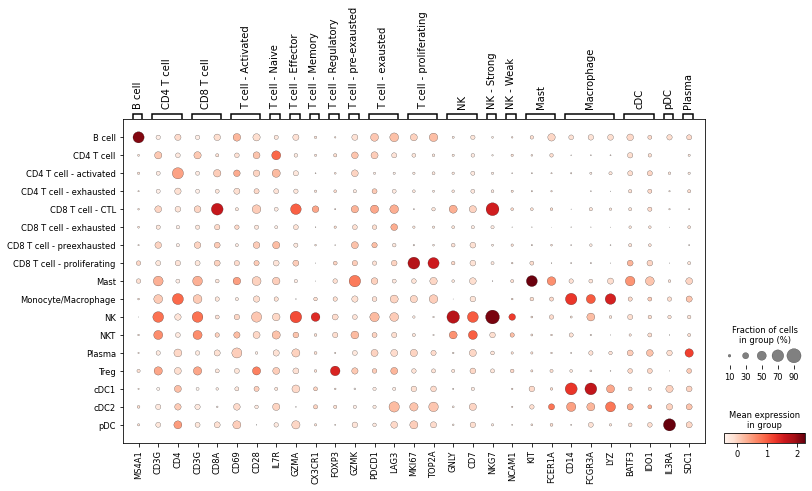

In [47]:
sc.pl.dotplot(feature_adata, marker_genes, groupby='predicted_cell_type', save='expression_dots.pdf')

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


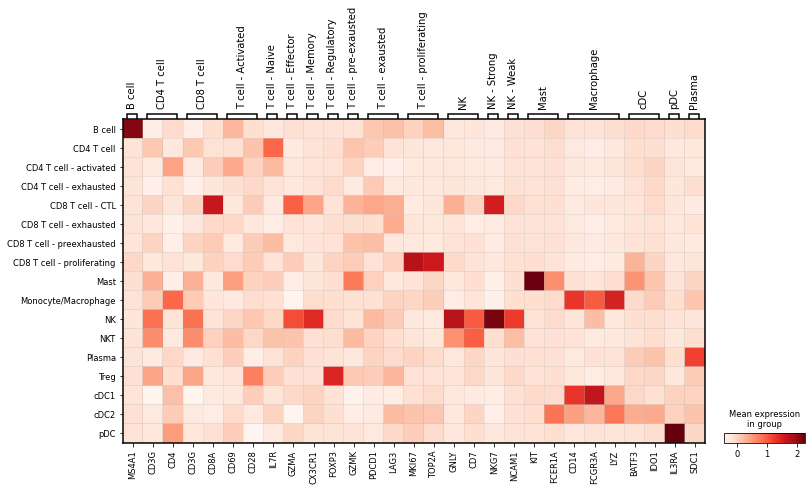

In [27]:
# p = feature_adata.copy()
# p.X = np.log1p(p.X*10000)
sc.pl.matrixplot(feature_adata, marker_genes, groupby='predicted_cell_type', cmap='Blues')

In [28]:
sc.tl.rank_genes_groups(feature_adata, groupby='predicted_cell_type', groups=sorted(set(feature_adata.obs['predicted_cell_type'])),
                       method='wilcoxon')

invalid value encountered in log2


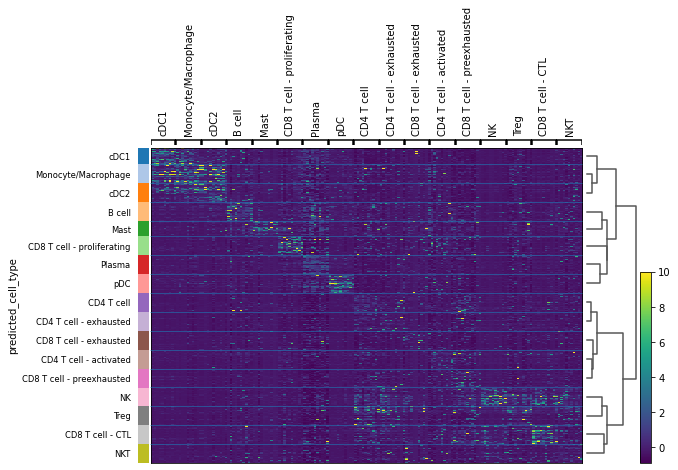

In [29]:
sc.pl.rank_genes_groups_heatmap(feature_adata, vmax=10., )

In [30]:
feature_adata.write_h5ad(os.path.join(DATA_DIR, 'explain_feature_adata_panimmune_breast_module.h5ad'))

In [31]:
DATA_DIR

'../benchmarking/sandbox/figure_data_v3'

In [32]:
list(feature_adata.uns['rank_genes_groups']['names']['CD8 T cell - proliferating'])[:10]

['TYMS',
 'TUBB',
 'TUFM',
 'MAD2L1',
 'MCM7',
 'CDC123',
 'MKI67',
 'NUSAP1',
 'HMGB2',
 'TUBA1B']

In [34]:
sc.tl.rank_genes_groups(combined, groupby='predicted_cell_type', method='wilcoxon')

overflow encountered in expm1


In [ ]:
list(combined.uns['rank_genes_groups']['names']['CD8 T cell - proliferating'])[:50]

In [261]:
list(feature_adata.uns['rank_genes_groups']['names']['CD8 T cell - exhausted'])[:10]

['LINC01871',
 'IFNG',
 'TNFRSF9',
 'MTERF3',
 'VCAM1',
 'LAG3',
 'NFRKB',
 'RASGRP1',
 'PADI4',
 'PTPN22']

In [ ]:
TYMS - https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0047318
    https://pubmed.ncbi.nlm.nih.gov/15355913/
        
HMGB1 - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3375072/
    https://pubmed.ncbi.nlm.nih.gov/28337869/

In [242]:
# !conda install -y -c conda-forge -c bioconda gseapy

In [243]:
import gseapy as gp

Creating directory /home/estorrs/.config/bioservices 


In [244]:
ls = list(feature_adata.uns['rank_genes_groups']['names']['CD8 T cell - proliferating'])

In [249]:
for g in feature_adata.uns['rank_genes_groups']['names']['CD8 T cell - proliferating'][:50]: print(g)

TYMS
TUBB
TUFM
MAD2L1
MCM7
CDC123
MKI67
NUSAP1
HMGB2
TUBA1B
F8A1
STMN1
RANBP1
HMGB1
LRRC40
RRM2
ADRM1
PSMA2
HMGN2
PCLAF
BIRC5
RHOF
EIF3D
TIMM10
SMC2
SMC4
MAPKAPK3
CDKN3
COPS7B
RAN
HDDC3
CUTC
MDH2
TRABD
CENPU
DDX39A
CENPM
TOP2A
ATAD2
NUP37
ITGAE
CORO1A
BRMS1
CENPF
FASTKD5
AK3
PCNA
TMEM106C
ZWINT
SKA2


In [251]:
go_pathways = pd.read_csv('../benchmarking/sandbox/go_biological_pathway_panimmune_explain.txt',
                         sep='\t')
go_pathways['-log10(FDR)'] = [-np.log10(x) for x in go_pathways['q-value FDR B&H']]
go_pathways

,Category,ID,Name,Source,p-value,q-value Bonferroni,q-value FDR B&H,q-value FDR B&Y,Hit Count in Query List,Hit Count in Genome,Hit in Query List,-log10(FDR)
0,GO: Biological Process,GO:0000278,mitotic cell cycle,,2.452000e-14,4.333000e-11,1.444000e-11,1.163000e-10,21,1108,"TYMS,NUSAP1,TUBA1B,CDKN3,RAN,RANBP1,CENPF,PSMA...",10.840433
1,GO: Biological Process,GO:0140014,mitotic nuclear division,,2.452000e-14,4.333000e-11,1.444000e-11,1.163000e-10,21,1108,"TYMS,NUSAP1,TUBA1B,CDKN3,RAN,RANBP1,CENPF,PSMA...",10.840433
2,GO: Biological Process,GO:1903047,mitotic cell cycle process,,2.452000e-14,4.333000e-11,1.444000e-11,1.163000e-10,21,1108,"TYMS,NUSAP1,TUBA1B,CDKN3,RAN,RANBP1,CENPF,PSMA...",10.840433
3,GO: Biological Process,GO:0000280,nuclear division,,3.616000e-14,6.390000e-11,1.598000e-11,1.287000e-10,22,1283,"TYMS,NUSAP1,TUBA1B,CDKN3,RAN,RANBP1,CENPF,PSMA...",10.796423
4,GO: Biological Process,GO:0022402,cell cycle process,,7.354000e-14,1.299000e-10,2.432000e-11,1.959000e-10,24,1671,"TYMS,NUSAP1,TUBA1B,CDKN3,RAN,RANBP1,CENPF,CDC1...",10.614036
...,...,...,...,...,...,...,...,...,...,...,...,...
117,GO: Biological Process,GO:0071353,cellular response to interleukin-4,,3.074000e-03,1.000000e+00,4.526000e-02,3.645000e-01,2,34,"TUBA1B,CORO1A",1.344285
118,GO: Biological Process,GO:0006409,tRNA export from nucleus,,3.074000e-03,1.000000e+00,4.526000e-02,3.645000e-01,2,34,"RAN,NUP37",1.344285
119,GO: Biological Process,GO:0071431,tRNA-containing ribonucleoprotein complex expo...,,3.074000e-03,1.000000e+00,4.526000e-02,3.645000e-01,2,34,"RAN,NUP37",1.344285
120,GO: Biological Process,GO:0097421,liver regeneration,,3.255000e-03,1.000000e+00,4.714000e-02,3.797000e-01,2,35,"TYMS,PCNA",1.326610


In [258]:
source = go_pathways.iloc[:10, :]
chart = alt.Chart(source, title='CD8 T cell - proliferating')
chart = chart.mark_circle().encode(
    y=alt.Y(f'Name:N', axis=alt.Axis(title=None), sort='-x'),
    x=alt.X(f'-log10(FDR):Q', scale=alt.Scale(zero=False), axis=alt.Axis(grid=True)),
)
chart

alt.Chart(...)

In [262]:
for g in feature_adata.uns['rank_genes_groups']['names']['CD8 T cell - exhausted'][:50]: print(g)

LINC01871
IFNG
TNFRSF9
MTERF3
VCAM1
LAG3
NFRKB
RASGRP1
PADI4
PTPN22
SYT11
ZNF599
UTP3
PUF60
LINC00158
PRDM1
NAA50
SLC25A6
AC068196.1
ZBED2
PCGF6
NHS
ENTPD3-AS1
FAM166B
AL031963.3
ABI1
ZNF460-AS1
PLGLB1
YBEY
LIMA1
AC006369.1
CARD17
ATF2
RPS18
GADD45A
AL160313.1
MRM1
IGLV3-21
LCN8
ZNF581
TRAV8-4
AC096734.1
NCR2
EGFL8
AC068338.2
NRTN
LINC01358
TUBB4A
AC016394.2
AC006064.4


In [263]:
go_pathways = pd.read_csv('../benchmarking/sandbox/go_biological_pathway_panimmune_explain_cd8_exausted.txt',
                         sep='\t')
go_pathways['-log10(FDR)'] = [-np.log10(x) for x in go_pathways['q-value FDR B&H']]
go_pathways

,Category,ID,Name,Source,p-value,q-value Bonferroni,q-value FDR B&H,q-value FDR B&Y,Hit Count in Query List,Hit Count in Genome,Hit in Query List,-log10(FDR)
0,GO: Biological Process,GO:1903037,regulation of leukocyte cell-cell adhesion,,2.218000e-07,0.000256,0.000143,0.001089,5,365,"IFNG,VCAM1,RASGRP1,LAG3,PTPN22",3.845272
1,GO: Biological Process,GO:0050863,regulation of T cell activation,,2.470000e-07,0.000286,0.000143,0.001089,5,373,"IFNG,VCAM1,RASGRP1,LAG3,PTPN22",3.845272
2,GO: Biological Process,GO:0007159,leukocyte cell-cell adhesion,,3.716000e-07,0.000430,0.000143,0.001093,5,405,"IFNG,VCAM1,RASGRP1,LAG3,PTPN22",3.844057
3,GO: Biological Process,GO:0030098,lymphocyte differentiation,,5.000000e-07,0.000578,0.000145,0.001103,5,430,"IFNG,VCAM1,RASGRP1,LAG3,PTPN22",3.840132
4,GO: Biological Process,GO:1903131,mononuclear cell differentiation,,9.160000e-07,0.001059,0.000186,0.001416,5,486,"IFNG,VCAM1,RASGRP1,LAG3,PTPN22",3.731422
...,...,...,...,...,...,...,...,...,...,...,...,...
415,GO: Biological Process,GO:0097242,amyloid-beta clearance,,1.767000e-02,1.000000,0.048910,0.373200,1,40,IFNG,1.310602
416,GO: Biological Process,GO:0033028,myeloid cell apoptotic process,,1.767000e-02,1.000000,0.048910,0.373200,1,40,IFNG,1.310602
417,GO: Biological Process,GO:1901701,cellular response to oxygen-containing compound,,1.769000e-02,1.000000,0.048910,0.373200,3,1330,"IFNG,VCAM1,PTPN22",1.310602
418,GO: Biological Process,GO:0045191,regulation of isotype switching,,1.811000e-02,1.000000,0.049850,0.380400,1,41,IFNG,1.302335


In [264]:
source = go_pathways.iloc[:10, :]
chart = alt.Chart(source, title='CD8 T cell - exausted')
chart = chart.mark_circle().encode(
    y=alt.Y(f'Name:N', axis=alt.Axis(title=None), sort='-x'),
    x=alt.X(f'-log10(FDR):Q', scale=alt.Scale(zero=False), axis=alt.Axis(grid=True)),
)
chart

alt.Chart(...)

In [265]:
for g in feature_adata.uns['rank_genes_groups']['names']['CD8 T cell - CTL'][:50]: print(g)

GZMH
NKG7
GZMM
FGFBP2
CST7
HOPX
CD8A
KLRG1
SPON2
BIN2
MATK
ILF3
MADD
PRF1
LSM8
PITPNC1
MED29
TDP1
CCDC69
AKNA
RBL2
KLRD1
ADGRG1
ATM
FLNA
TSNAX
PTPN4
C6orf89
APMAP
FNBP4
EPB41L4A-AS1
CTSW
RASSF1
STAMBP
LONP2
ZNF292
RNF125
ORAI1
MRPS21
DYNC1LI1
ZCCHC17
ARHGAP30
TAF7
NCR3
CCND3
SNHG15
ADAM17
ARMH1
SETD3
MUS81


In [266]:
go_pathways = pd.read_csv('../benchmarking/sandbox/go_biological_pathway_panimmune_explain_cd8_ctl.txt',
                         sep='\t')
go_pathways['-log10(FDR)'] = [-np.log10(x) for x in go_pathways['q-value FDR B&H']]
go_pathways

,Category,ID,Name,Source,p-value,q-value Bonferroni,q-value FDR B&H,q-value FDR B&Y,Hit Count in Query List,Hit Count in Genome,Hit in Query List,-log10(FDR)
0,GO: Biological Process,GO:0006952,defense response,,0.000012,0.01429,0.00677,0.05190,11,1935,"AKNA,FLNA,CST7,ATM,ILF3,CD8A,KLRG1,PRF1,KLRD1,...",2.169411
1,GO: Biological Process,GO:0019835,cytolysis,,0.000013,0.01572,0.00677,0.05190,3,36,"PRF1,GZMH,GZMM",2.169411
2,GO: Biological Process,GO:0002456,T cell mediated immunity,,0.000024,0.02870,0.00677,0.05190,4,133,"CD8A,PRF1,KLRD1,GZMM",2.169411
3,GO: Biological Process,GO:0051607,defense response to virus,,0.000028,0.03385,0.00677,0.05190,5,286,"FLNA,ILF3,CD8A,PRF1,SPON2",2.169411
4,GO: Biological Process,GO:0140546,defense response to symbiont,,0.000028,0.03385,0.00677,0.05190,5,286,"FLNA,ILF3,CD8A,PRF1,SPON2",2.169411
5,GO: Biological Process,GO:0001913,T cell mediated cytotoxicity,,0.000059,0.07020,0.01170,0.08971,3,59,"PRF1,KLRD1,GZMM",1.931814
6,GO: Biological Process,GO:0009615,response to virus,,0.000116,0.13850,0.01979,0.15170,5,385,"FLNA,ILF3,CD8A,PRF1,SPON2",1.703554
7,GO: Biological Process,GO:0098542,defense response to other organism,,0.000145,0.17410,0.02176,0.16690,8,1285,"FLNA,ILF3,CD8A,KLRG1,PRF1,KLRD1,SPON2,GZMM",1.662341
8,GO: Biological Process,GO:0002252,immune effector process,,0.000254,0.30410,0.03379,0.25910,8,1393,"FLNA,BIN2,ILF3,CD8A,PRF1,KLRD1,SPON2,GZMM",1.471212
9,GO: Biological Process,GO:1903978,regulation of microglial cell activation,,0.000329,0.39460,0.03946,0.30260,2,21,"CST7,ATM",1.403843


In [267]:
source = go_pathways.iloc[:10, :]
chart = alt.Chart(source, title='CD8 T cell - CTL')
chart = chart.mark_circle().encode(
    y=alt.Y(f'Name:N', axis=alt.Axis(title=None), sort='-x'),
    x=alt.X(f'-log10(FDR):Q', scale=alt.Scale(zero=False), axis=alt.Axis(grid=True)),
)
chart

alt.Chart(...)

In [268]:
for g in feature_adata.uns['rank_genes_groups']['names']['NK'][:50]: print(g)

PRF1
NKG7
HOPX
SPON2
KLRF1
KLRD1
GNLY
NCR3
AKNA
APMAP
CST7
C1orf21
SUMO1
ATM
MATK
TXK
GTF2A2
CD247
LSM8
FGFBP2
DYNLRB1
MRPL54
HELZ
PFDN2
PTPN4
ADGRE5
RNF125
EZH1
MAPK1
PPP1CC
UQCRC2
GK5
TRDC
CTSW
MDH1
RWDD1
SNRPB2
MRPL12
LSM2
DIP2A
PSMB7
RASSF1
ZNF706
MADD
THOC3
NDUFB9
TTC38
TAF9
STK26
LYRM4


In [269]:
go_pathways = pd.read_csv('../benchmarking/sandbox/go_biological_pathway_panimmune_explain_nk.txt',
                         sep='\t')
go_pathways['-log10(FDR)'] = [-np.log10(x) for x in go_pathways['q-value FDR B&H']]
go_pathways

,Category,ID,Name,Source,p-value,q-value Bonferroni,q-value FDR B&H,q-value FDR B&Y,Hit Count in Query List,Hit Count in Genome,Hit in Query List,-log10(FDR)
0,GO: Biological Process,GO:0001906,cell killing,,0.000003,0.000672,0.000654,0.004004,4,218,"KLRD1,GNLY,NCR3,PRF1",3.184555
1,GO: Biological Process,GO:0031343,positive regulation of cell killing,,0.000005,0.001308,0.000654,0.004004,3,72,"KLRD1,NCR3,PRF1",3.184555
2,GO: Biological Process,GO:0031341,regulation of cell killing,,0.000020,0.005079,0.001693,0.010370,3,113,"KLRD1,NCR3,PRF1",2.771343
3,GO: Biological Process,GO:0001909,leukocyte mediated cytotoxicity,,0.000032,0.008272,0.002068,0.012660,3,133,"KLRD1,NCR3,PRF1",2.684449
4,GO: Biological Process,GO:0045954,positive regulation of natural killer cell med...,,0.000083,0.021170,0.004219,0.025840,2,28,"KLRD1,NCR3",2.374790
...,...,...,...,...,...,...,...,...,...,...,...,...
57,GO: Biological Process,GO:0051131,chaperone-mediated protein complex assembly,,0.010830,1.000000,0.046020,0.281900,1,22,HOPX,1.337053
58,GO: Biological Process,GO:0045953,negative regulation of natural killer cell med...,,0.010830,1.000000,0.046020,0.281900,1,22,KLRD1,1.337053
59,GO: Biological Process,GO:0061081,positive regulation of myeloid leukocyte cytok...,,0.010830,1.000000,0.046020,0.281900,1,22,SPON2,1.337053
60,GO: Biological Process,GO:0045088,regulation of innate immune response,,0.010970,1.000000,0.046020,0.281900,2,330,"KLRD1,NCR3",1.337053


In [270]:
source = go_pathways.iloc[:10, :]
chart = alt.Chart(source, title='NK')
chart = chart.mark_circle().encode(
    y=alt.Y(f'Name:N', axis=alt.Axis(title=None), sort='-x'),
    x=alt.X(f'-log10(FDR):Q', scale=alt.Scale(zero=False), axis=alt.Axis(grid=True)),
)
chart

alt.Chart(...)

B cell


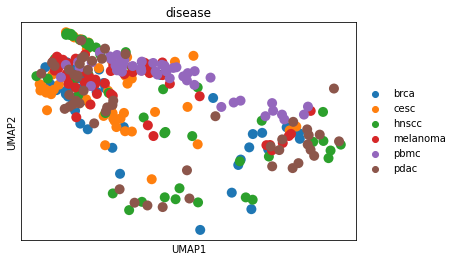

CD4 T cell


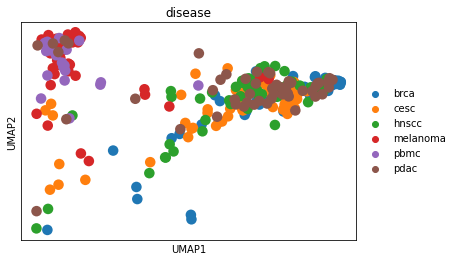

CD4 T cell - RP-high


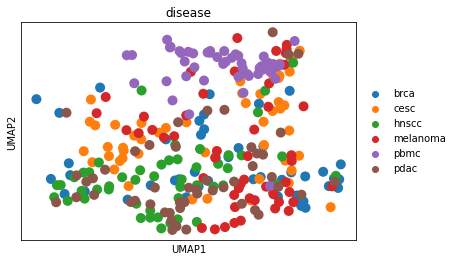

CD4 T cell - activated


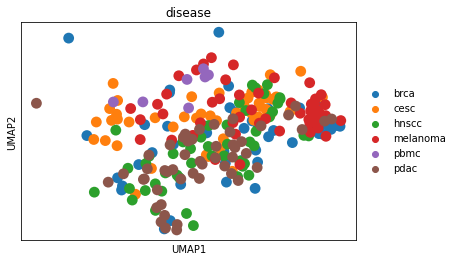

CD4 T cell - exhausted


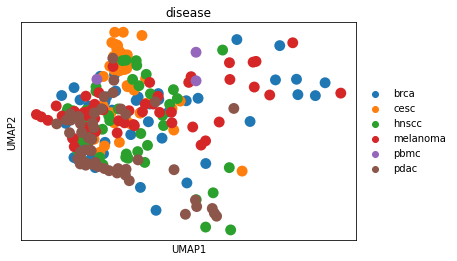

CD8 T cell - CTL


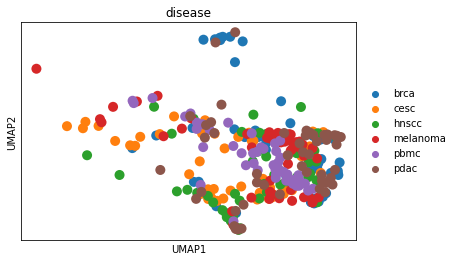

CD8 T cell - exhausted


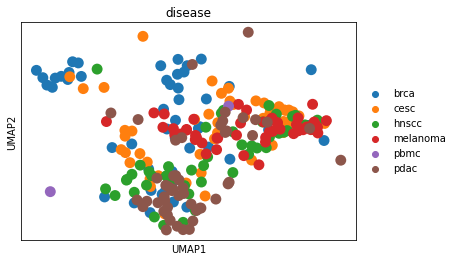

CD8 T cell - preexhausted


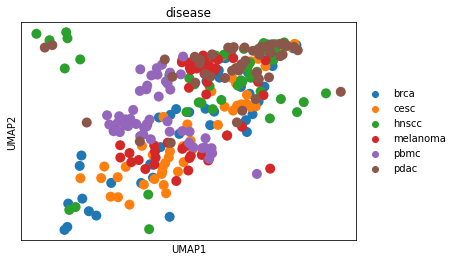

CD8 T cell - proliferating


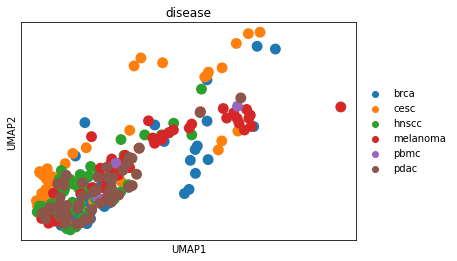

Mast


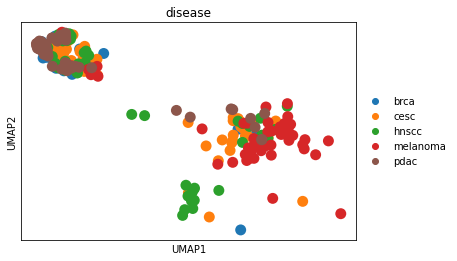

Monocyte/Macrophage


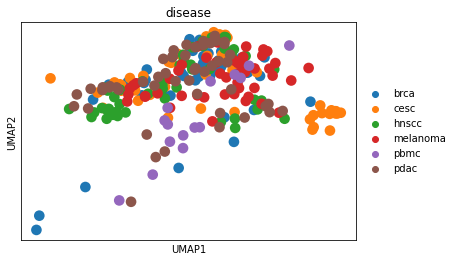

NKT


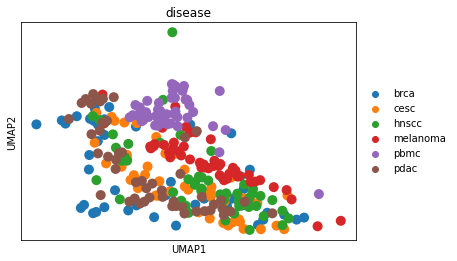

Plasma


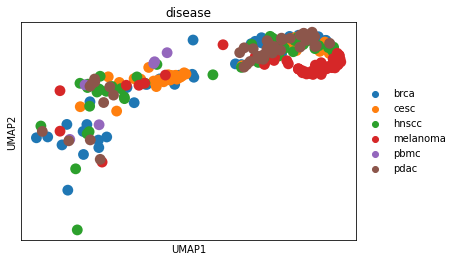

Treg


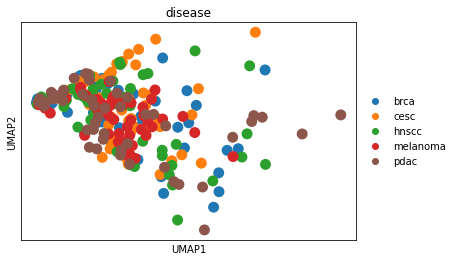

cDC1


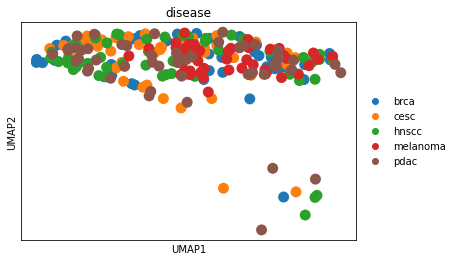

cDC2


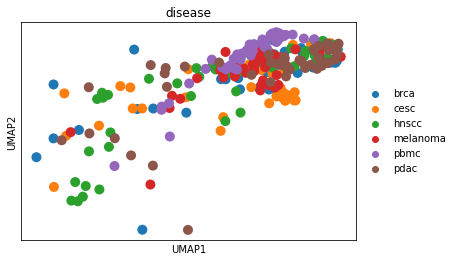

pDC


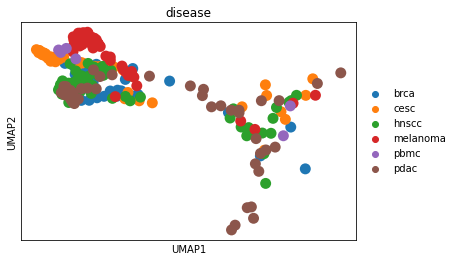

In [64]:
for ct in sorted(set(feature_adata.obs['predicted_cell_type'])):
    print(ct)
    sc.pl.umap(feature_adata[feature_adata.obs['predicted_cell_type']==ct], color='disease')
    plt.show()

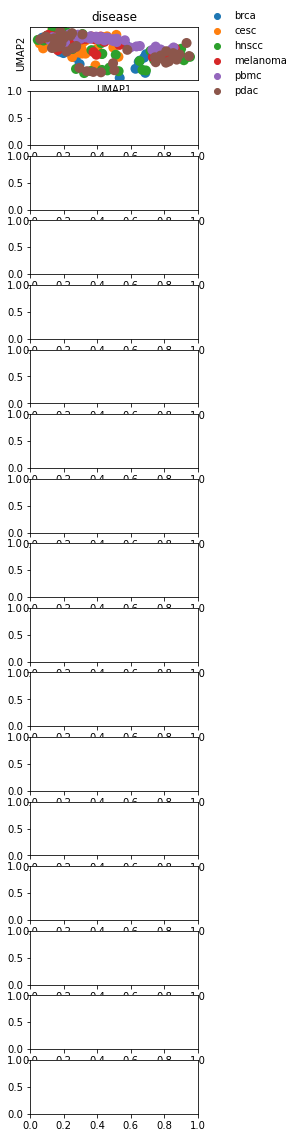

In [96]:
cts = sorted(set(feature_adata.obs['predicted_cell_type']))
fig, axs = plt.subplots(nrows=len(cts), figsize=(3, 20))
for i, ct in enumerate(cts):
#     print(ct)
    axs[i].set_title(ct)
    sc.pl.umap(feature_adata[feature_adata.obs['predicted_cell_type']==ct], color='disease', ax=axs[i])
    

In [90]:
target = feature_adata[feature_adata.obs['predicted_cell_type']=='Plasma'].copy()
# recluster 
sc.pp.neighbors(target)
sc.pp.pca(target)

sc.tl.umap(target)
sc.tl.leiden(target, resolution=.2)
target

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


AnnData object with n_obs × n_vars = 256 × 27131
    obs: 'cell_type', 'predicted_cell_type', 'cell_type_probability', 'probability_B cell', 'probability_CD4 T cell', 'probability_CD4 T cell - RP-high', 'probability_CD4 T cell - activated', 'probability_CD4 T cell - exhausted', 'probability_CD8 T cell - CTL', 'probability_CD8 T cell - exhausted', 'probability_CD8 T cell - preexhausted', 'probability_CD8 T cell - proliferating', 'probability_Mast', 'probability_Monocyte/Macrophage', 'probability_NKT', 'probability_Plasma', 'probability_Treg', 'probability_cDC1', 'probability_cDC2', 'probability_pDC', 'disease', 'leiden'
    uns: 'neighbors', 'pca', 'umap', 'leiden', 'predicted_cell_type_colors', 'disease_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

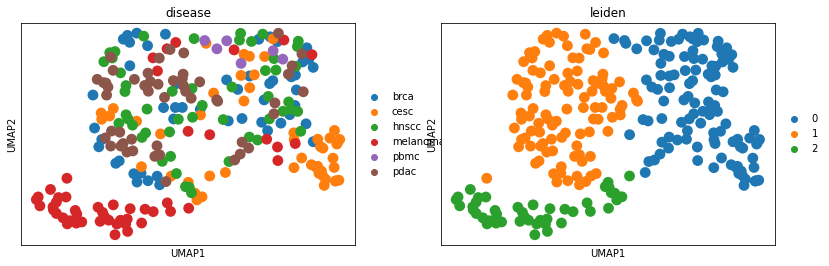

In [91]:
sc.pl.umap(target, color=['disease', 'leiden'])

... storing 'cluster' as categorical


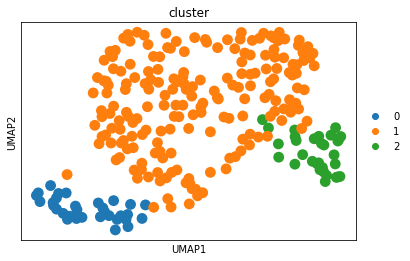

In [72]:
c2c = {
    '0': ['2'],
    '1': ['0', '1', '3', '5', '6', '7'],
    '2': ['4']
}
c2c = {v:k for k, vs in c2c.items() for v in vs}
target.obs['cluster'] = [c2c[c] for c in target.obs['leiden']]
sc.pl.umap(target, color='cluster')

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'cluster' as categorical
invalid value encountered in log2
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


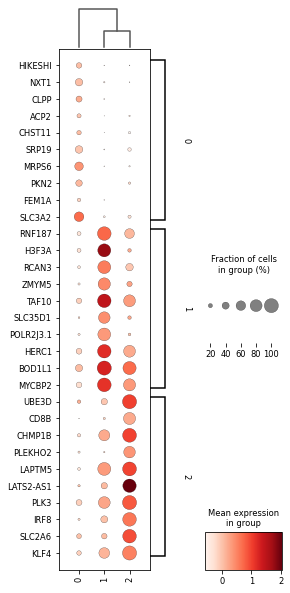

In [100]:
target.obs['cluster']=target.obs['leiden'].to_list()
sc.tl.rank_genes_groups(target, groupby='cluster', method='wilcoxon', )
sc.pl.rank_genes_groups_dotplot(target, swap_axes=True, figsize=(4, 10))

In [ ]:
sc.pl.dotplot()

In [46]:
small = explain[explain.obs['disease']=='brca'].copy()

sc.pp.scale(small)
sc.pp.neighbors(small)
sc.pp.pca(small)

sc.tl.umap(small)
sc.tl.leiden(small, resolution=1.)
small

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


         Falling back to preprocessing with `sc.pp.pca` and default params.


AnnData object with n_obs × n_vars = 850 × 27131
    obs: 'cell_type', 'predicted_cell_type', 'cell_type_probability', 'probability_B cell', 'probability_CD4 T cell', 'probability_CD4 T cell - RP-high', 'probability_CD4 T cell - activated', 'probability_CD4 T cell - exhausted', 'probability_CD8 T cell - CTL', 'probability_CD8 T cell - exhausted', 'probability_CD8 T cell - preexhausted', 'probability_CD8 T cell - proliferating', 'probability_Mast', 'probability_Monocyte/Macrophage', 'probability_NKT', 'probability_Plasma', 'probability_Treg', 'probability_cDC1', 'probability_cDC2', 'probability_pDC', 'disease', 'leiden'
    var: 'mean', 'std'
    uns: 'neighbors', 'pca', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


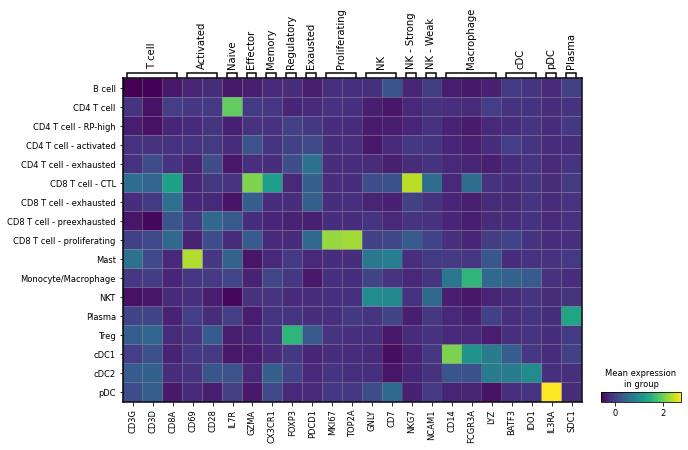

In [49]:
sc.pl.matrixplot(small, marker_genes, groupby='predicted_cell_type')

In [48]:
set(adata.obs['cell_type'])

{'CD4 T cell',
 'CD8 T cell',
 'Dendritic',
 'Mast',
 'Monocyte',
 'NK',
 'Plasma',
 'Treg'}